# Heatmap


In [1]:
# Install once if not yet installed
install.packages("pheatmap")


  Es gibt eine Binärversion, jedoch ist der Quelltext neuer:
         binary source needs_compilation
pheatmap 1.0.12 1.0.13             FALSE



installiere Quellpaket 'pheatmap'




In [2]:
# Load libraries
library(readxl)
library(dplyr)
library(pheatmap)

# Load the data
data_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA.xlsx"
df <- read_excel(data_path, sheet = "FINAL_final_final")



Attache Paket: 'dplyr'


Die folgenden Objekte sind maskiert von 'package:stats':

    filter, lag


Die folgenden Objekte sind maskiert von 'package:base':

    intersect, setdiff, setequal, union


New names:
• `SpCond_uSpercm` -> `SpCond_uSpercm...41`
• `SpCond_uSpercm` -> `SpCond_uSpercm...42`


[1] "✅ Unique river names found:"
[1] "Vestari_Joekulsa" "Virkisa"         


📊 Processing river: Vestari_Joekulsa



[1] "✅ Rows after filtering: 41"
[1] 0.19880 0.04521 0.18130


📊 Processing river: Virkisa



[1] "✅ Rows after filtering: 106"
[1] 0.11140 0.09737 0.13850


Warning message in cor(selected_vars, use = "pairwise.complete.obs"):
"Standardabweichung ist Null"


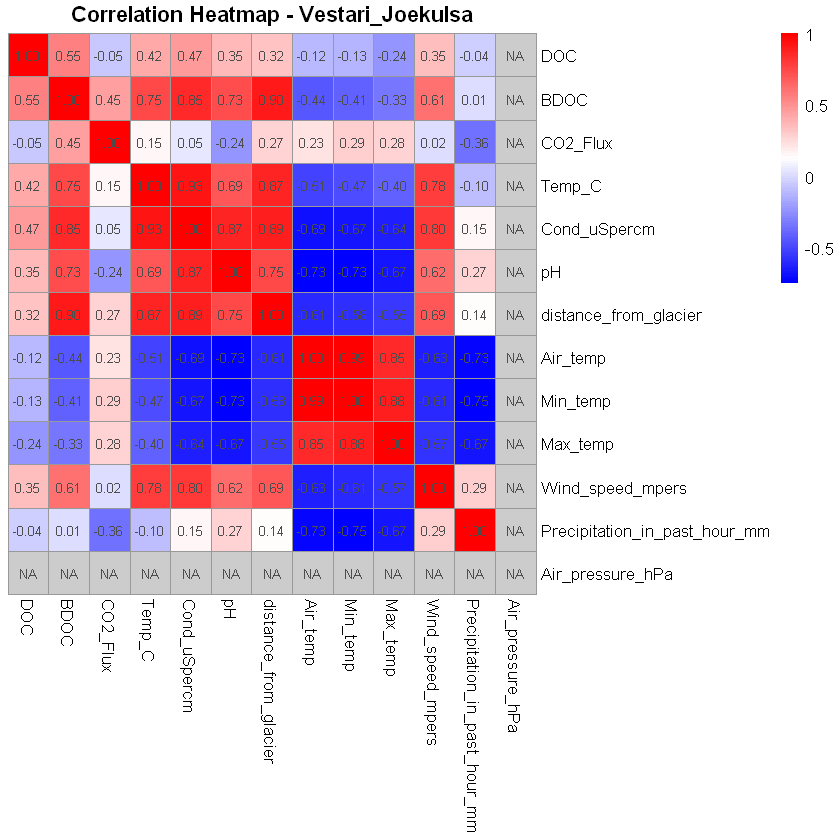

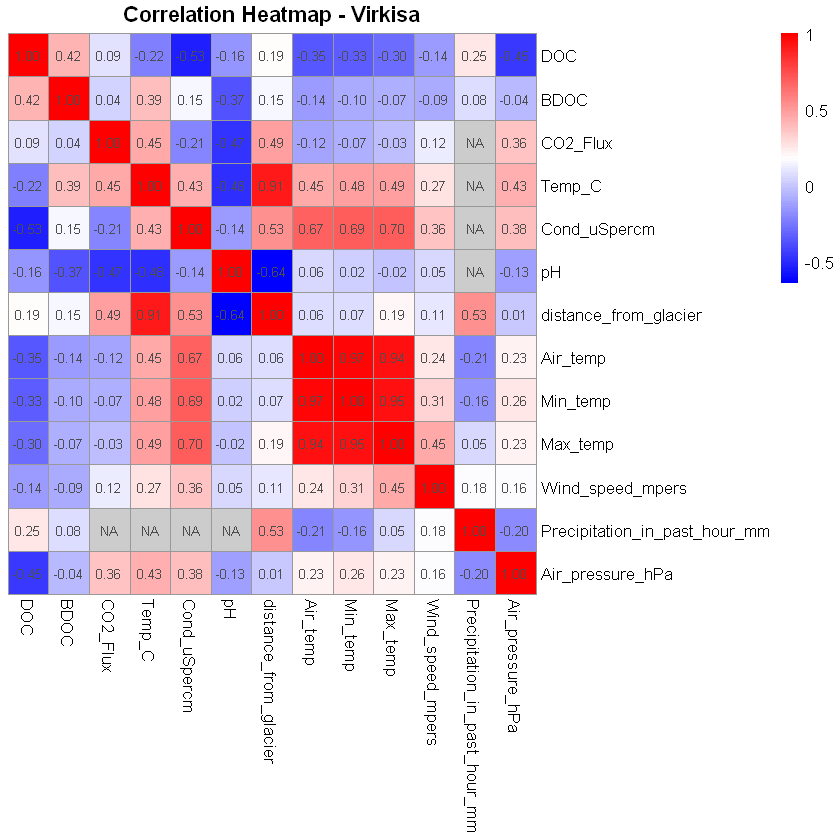

In [4]:
# Clean column names and string values
colnames(df) <- trimws(colnames(df))
df$river_name <- trimws(as.character(df$river_name))

# Print unique values for safety
print("✅ Unique river names found:")
print(unique(df$river_name))

# Define your variable list (fixed axis structure)
all_vars <- c(
  "DOC", "BDOC", "CO2_Flux",
  "Temp_C", "Cond_uSpercm", "pH",
  "distance_from_glacier", "Air_temp",
  "Min_temp", "Max_temp",
  "Wind_speed_mpers",
  "Precipitation_in_past_hour_mm",
  "Air_pressure_hPa"
)

# Function to generate and plot the heatmap
plot_corr_pheatmap_by_river <- function(data, river_filter) {
  message("📊 Processing river: ", river_filter)

  # Filter safely
  df_river <- data %>% filter(trimws(river_name) == river_filter)

  # Double-check it's working
  print(paste("✅ Rows after filtering:", nrow(df_river)))
  print(head(df_river$DOC, 3))

  # Select variables
  selected_vars <- df_river %>%
    select(any_of(all_vars)) %>%
    mutate(across(everything(), as.numeric))

  # Compute correlation matrix
  cor_matrix <- cor(selected_vars, use = "pairwise.complete.obs")

  # Add missing variables back as NA rows/cols
  missing_vars <- setdiff(all_vars, rownames(cor_matrix))
  for (var in missing_vars) {
    cor_matrix <- rbind(cor_matrix, setNames(rep(NA, ncol(cor_matrix)), colnames(cor_matrix)))
    rownames(cor_matrix)[nrow(cor_matrix)] <- var
    cor_matrix <- cbind(cor_matrix, setNames(rep(NA, nrow(cor_matrix)), var))
  }

  # Reorder matrix
  cor_matrix <- cor_matrix[all_vars, all_vars]

#----------------
#----------------

#  Block nach dem Re-Ordering ein
#    (direkt vor pheatmap)
# -------------------------------------------------
# Nur die untere Hälfte + Diagonale anzeigen
#cor_matrix[upper.tri(cor_matrix, diag = FALSE)] <- NA
# -------------------------------------------------

#pheatmap(
#  cor_matrix,
#  cluster_rows = FALSE,
#  cluster_cols = FALSE,
#  display_numbers = TRUE,
#  number_format = "%.2f",
#  color = colorRampPalette(c("blue", "white", "red"))(100),
#  main = paste("Correlation Heatmap -", river_filter),
#  na_col = "grey80"
#)

#---------------
#---------------



    
  # Plot heatmap
  pheatmap(
    cor_matrix,
    cluster_rows = FALSE,
    cluster_cols = FALSE,
    display_numbers = TRUE,
    number_format = "%.2f",
    color = colorRampPalette(c("blue", "white", "red"))(100),
    main = paste("Correlation Heatmap -", river_filter),
    na_col = "grey80"
  )
}

# ✅ Now run this:
plot_corr_pheatmap_by_river(df, "Vestari_Joekulsa")
plot_corr_pheatmap_by_river(df, "Virkisa")


In [4]:
table(df$river_name)


Vestari_Joekulsa          Virkisa 
              41              106 

In [3]:
summary(df[df$river_name == "Vestari_Joekulsa", "DOC"])
summary(df[df$river_name == "Virkisa", "DOC"])

      DOC         
 Min.   :0.03884  
 1st Qu.:0.10162  
 Median :0.14760  
 Mean   :0.14382  
 3rd Qu.:0.18272  
 Max.   :0.24640  
 NA's   :1        

      DOC         
 Min.   :0.08016  
 1st Qu.:0.13850  
 Median :0.19770  
 Mean   :0.24685  
 3rd Qu.:0.29010  
 Max.   :0.87020  
 NA's   :1        

# ----------------------------------------------------------------------------
# ____________________________________________________________________________


# ✅ Wetter + Kohlenstoff, für beide Flüsse

In [1]:
# 📦 Pakete laden
library(readxl)
library(dplyr)
library(pheatmap)
library(grid)
library(rlang)

# 📥 Excel-Datei laden
data_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA.xlsx"
df <- read_excel(data_path, sheet = "FINAL_final_final")
colnames(df) <- trimws(colnames(df))
df$river_name <- trimws(as.character(df$river_name))
df$group_nr <- as.numeric(df$group_nr)

# 📁 Zielordner
output_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/Wetter"

# 🔬 Variablen: Wetter & Kohlenstoff
all_vars <- c(
  "DOC", "BDOC", "CO2_Flux",
  "Air_temp", "Min_temp", "Max_temp",
  "Wind_speed_mpers", "Precipitation_in_past_hour_mm",
  "Air_pressure_hPa"
)

# 🔁 Funktion: Heatmap erzeugen, anzeigen und speichern
plot_and_save_heatmap <- function(data, filter_expr, filename_suffix, title_suffix) {
  message("📊 Verarbeite: ", title_suffix)
  
  df_filtered <- data %>% filter(!!parse_expr(filter_expr))
  selected_vars <- df_filtered %>%
    select(any_of(all_vars)) %>%
    mutate(across(everything(), as.numeric))

  if (nrow(selected_vars) < 2 || ncol(selected_vars) < 2) {
    message("⚠️ Nicht genügend Daten: ", title_suffix)
    return(NULL)
  }

  # Korrelation berechnen
  cor_matrix <- cor(selected_vars, use = "pairwise.complete.obs")
  
  # Fehlende Variablen ergänzen
  missing_vars <- setdiff(all_vars, rownames(cor_matrix))
  for (var in missing_vars) {
    cor_matrix <- rbind(cor_matrix, setNames(rep(NA, ncol(cor_matrix)), colnames(cor_matrix)))
    rownames(cor_matrix)[nrow(cor_matrix)] <- var
    cor_matrix <- cbind(cor_matrix, setNames(rep(NA, nrow(cor_matrix)), var))
  }
  cor_matrix <- cor_matrix[all_vars, all_vars]

  # 🔥 Heatmap erstellen & im Notebook anzeigen
  p <- pheatmap(
    cor_matrix,
    cluster_rows = FALSE,
    cluster_cols = FALSE,
    display_numbers = TRUE,
    number_format = "%.2f",
    color = colorRampPalette(c("blue", "white", "red"))(100),
    main = paste("Korrelations-Heatmap –", title_suffix),
    na_col = "grey80",
    silent = TRUE
  )

  # Notebook-Anzeige:
  grid.newpage()
  grid.draw(p$gtable)

  # 💾 Speichern
  file_name <- paste0("heatmap_", filename_suffix, "_wetter.png")
  file_path <- file.path(output_dir, file_name)
  
  png(file_path, width = 2000, height = 1800, res = 250)
  grid.newpage()
  grid.draw(p$gtable)
  dev.off()
  
  message("✅ Gespeichert: ", file_path)
}



Attache Paket: 'dplyr'


Die folgenden Objekte sind maskiert von 'package:stats':

    filter, lag


Die folgenden Objekte sind maskiert von 'package:base':

    intersect, setdiff, setequal, union


New names:
• `SpCond_uSpercm` -> `SpCond_uSpercm...41`
• `SpCond_uSpercm` -> `SpCond_uSpercm...42`


📊 Verarbeite: Vestari_Joekulsa

✅ Gespeichert: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/Wetter/heatmap_Vestari_Joekulsa_wetter.png

📊 Verarbeite: Virkisa

Warning message in cor(selected_vars, use = "pairwise.complete.obs"):
"Standardabweichung ist Null"


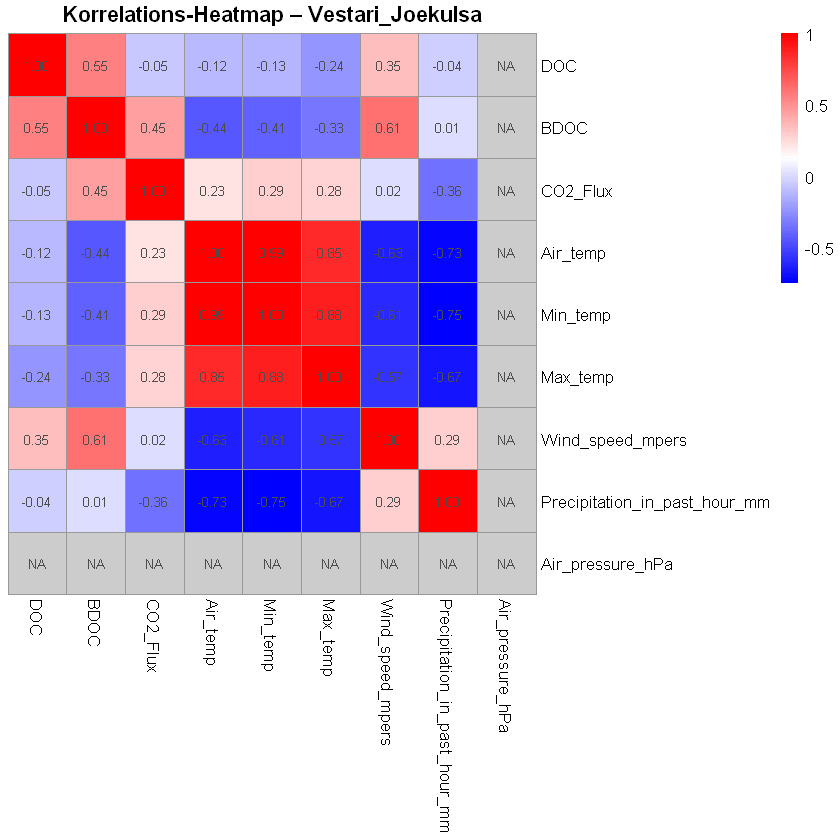

✅ Gespeichert: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/Wetter/heatmap_Virkisa_wetter.png

📊 Verarbeite: Virkisa (group_nr = 1)

Warning message in cor(selected_vars, use = "pairwise.complete.obs"):
"Standardabweichung ist Null"


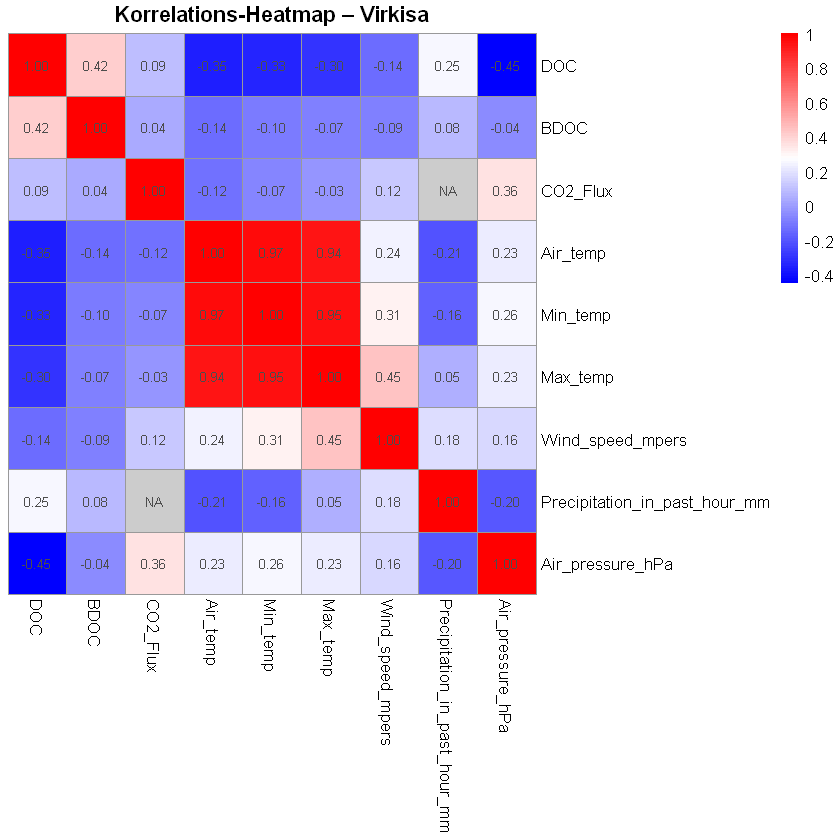

✅ Gespeichert: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/Wetter/heatmap_Virkisa_group1_wetter.png

📊 Verarbeite: Virkisa (group_nr > 1)

Warning message in cor(selected_vars, use = "pairwise.complete.obs"):
"Standardabweichung ist Null"


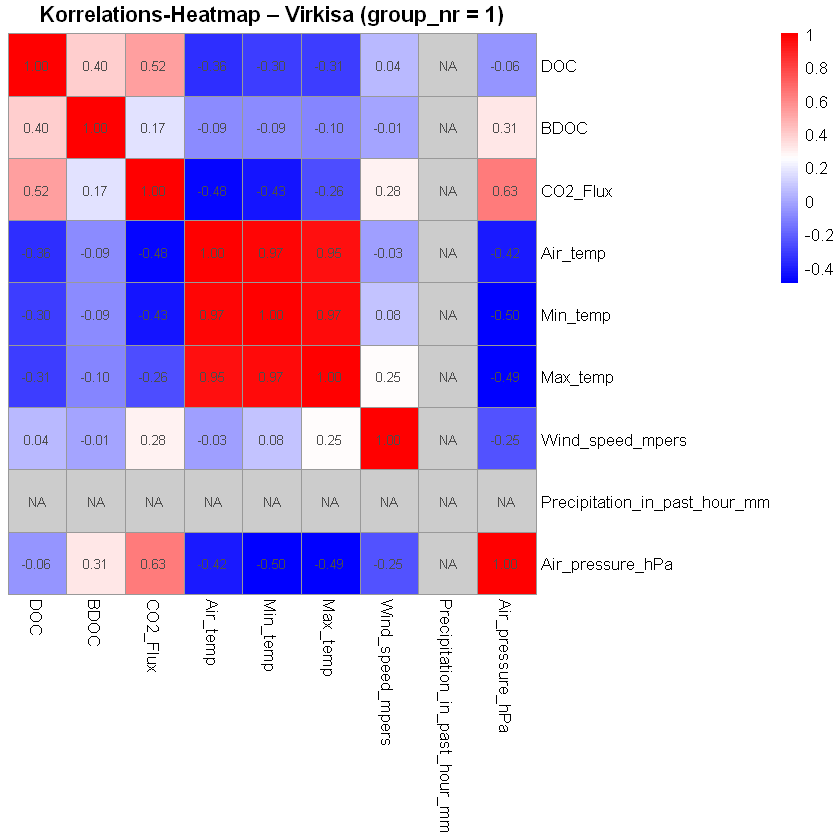

✅ Gespeichert: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/Wetter/heatmap_Virkisa_group_gt1_wetter.png



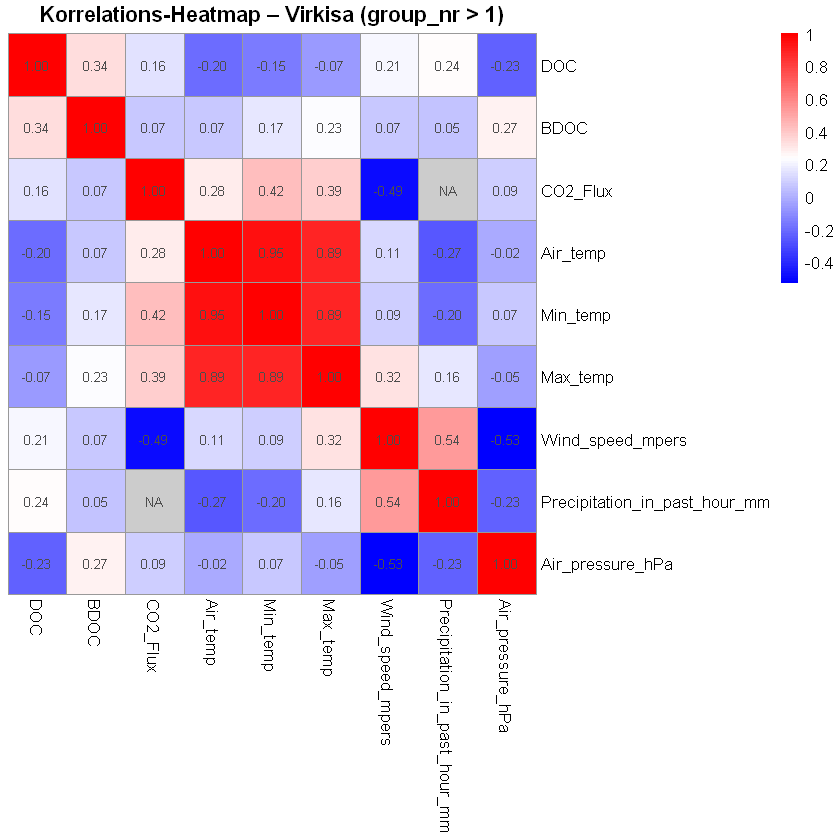

In [2]:
plot_and_save_heatmap(df, 'river_name == "Vestari_Joekulsa"', "Vestari_Joekulsa", "Vestari_Joekulsa")
plot_and_save_heatmap(df, 'river_name == "Virkisa"', "Virkisa", "Virkisa")
plot_and_save_heatmap(df, 'river_name == "Virkisa" & group_nr == 1', "Virkisa_group1", "Virkisa (group_nr = 1)")
plot_and_save_heatmap(df, 'river_name == "Virkisa" & group_nr > 1', "Virkisa_group_gt1", "Virkisa (group_nr > 1)")


# Chemische Parameter als Heatmap je Fluss

In [3]:
# 📦 Pakete laden
library(readxl)
library(dplyr)
library(pheatmap)
library(grid)
library(rlang)

# 📥 Daten einlesen
data_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA.xlsx"
df <- read_excel(data_path, sheet = "FINAL_final_final")

# ✂️ Spalten bereinigen
colnames(df) <- trimws(colnames(df))
df$river_name <- trimws(as.character(df$river_name))
df$group_nr <- as.numeric(df$group_nr)

# 📁 Zielordner für chemische Heatmaps
output_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/Chemisch"

# 🧪 Chemische Parameter
all_vars <- c(
  "DOC",
  "BDOC",
  "CO2_Flux", 
  "pH",
  "Cond_uSpercm",
  "TDS_mgperL",
  "ODO_mgperL",
  "Turbidity_FNU",
  "Chlorophyll_ugperL",
  "fDOM_QSU"
)

# 🔁 Funktion zur Erstellung, Anzeige & Speicherung der Heatmap
plot_and_save_chem_heatmap <- function(data, filter_expr, filename_suffix, title_suffix) {
  message("📊 Verarbeite Gruppe: ", title_suffix)

  df_filtered <- data %>% filter(!!parse_expr(filter_expr))

  selected_vars <- df_filtered %>%
    select(any_of(all_vars)) %>%
    mutate(across(everything(), as.numeric))

  message("✅ Stichprobenanzahl: ", nrow(selected_vars))

  if (nrow(selected_vars) < 2 || ncol(selected_vars) < 2) {
    message("⚠️ Nicht genügend Daten: ", title_suffix)
    return(NULL)
  }

  # Korrelation berechnen
  cor_matrix <- cor(selected_vars, use = "pairwise.complete.obs")

  # Fehlende Variablen ergänzen
  missing_vars <- setdiff(all_vars, rownames(cor_matrix))
  for (var in missing_vars) {
    cor_matrix <- rbind(cor_matrix, setNames(rep(NA, ncol(cor_matrix)), colnames(cor_matrix)))
    rownames(cor_matrix)[nrow(cor_matrix)] <- var
    cor_matrix <- cbind(cor_matrix, setNames(rep(NA, nrow(cor_matrix)), var))
  }

  cor_matrix <- cor_matrix[all_vars, all_vars]

  # 📈 Heatmap erstellen
  p <- pheatmap(
    cor_matrix,
    cluster_rows = FALSE,
    cluster_cols = FALSE,
    display_numbers = TRUE,
    number_format = "%.2f",
    color = colorRampPalette(c("blue", "white", "red"))(100),
    main = paste("Korrelations-Heatmap –", title_suffix),
    na_col = "grey80",
    silent = TRUE
  )

  # 📺 Anzeige im Notebook
  grid.newpage()
  grid.draw(p$gtable)

  # 💾 Speichern
  file_name <- paste0("heatmap_", filename_suffix, "_chemisch.png")
  file_path <- file.path(output_dir, file_name)
  png(file_path, width = 2000, height = 1800, res = 250)
  grid.newpage()
  grid.draw(p$gtable)
  dev.off()
  message("✅ PNG gespeichert unter: ", file_path)
}


New names:
• `SpCond_uSpercm` -> `SpCond_uSpercm...41`
• `SpCond_uSpercm` -> `SpCond_uSpercm...42`


📊 Verarbeite Gruppe: Vestari_Joekulsa

✅ Stichprobenanzahl: 41

✅ PNG gespeichert unter: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/Chemisch/heatmap_Vestari_Joekulsa_chemisch.png

📊 Verarbeite Gruppe: Virkisa

✅ Stichprobenanzahl: 106



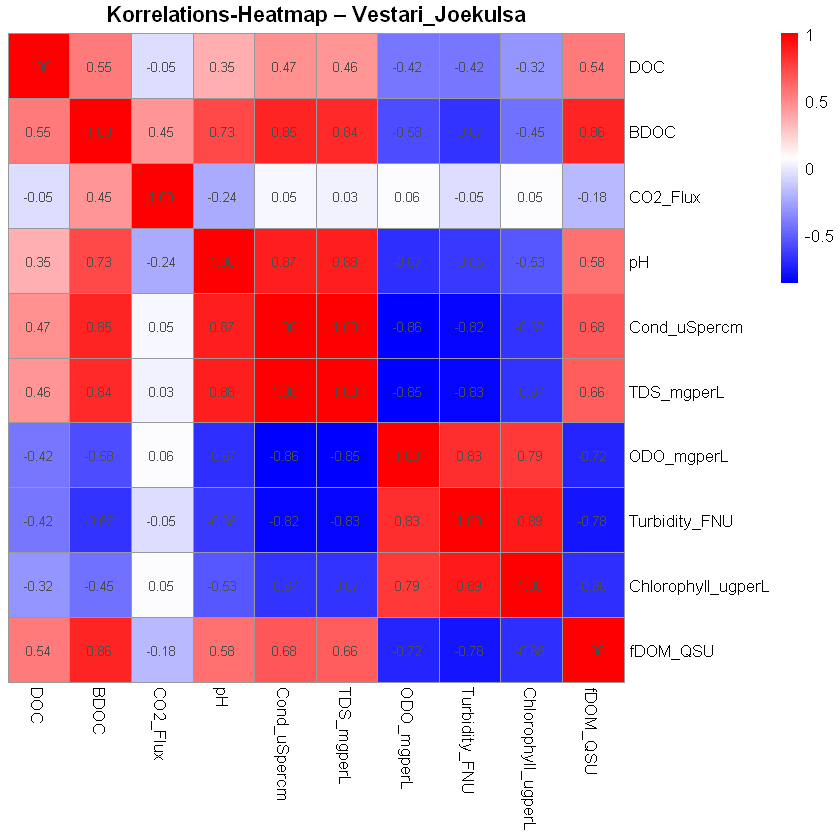

✅ PNG gespeichert unter: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/Chemisch/heatmap_Virkisa_chemisch.png

📊 Verarbeite Gruppe: Virkisa (group_nr = 1)

✅ Stichprobenanzahl: 32



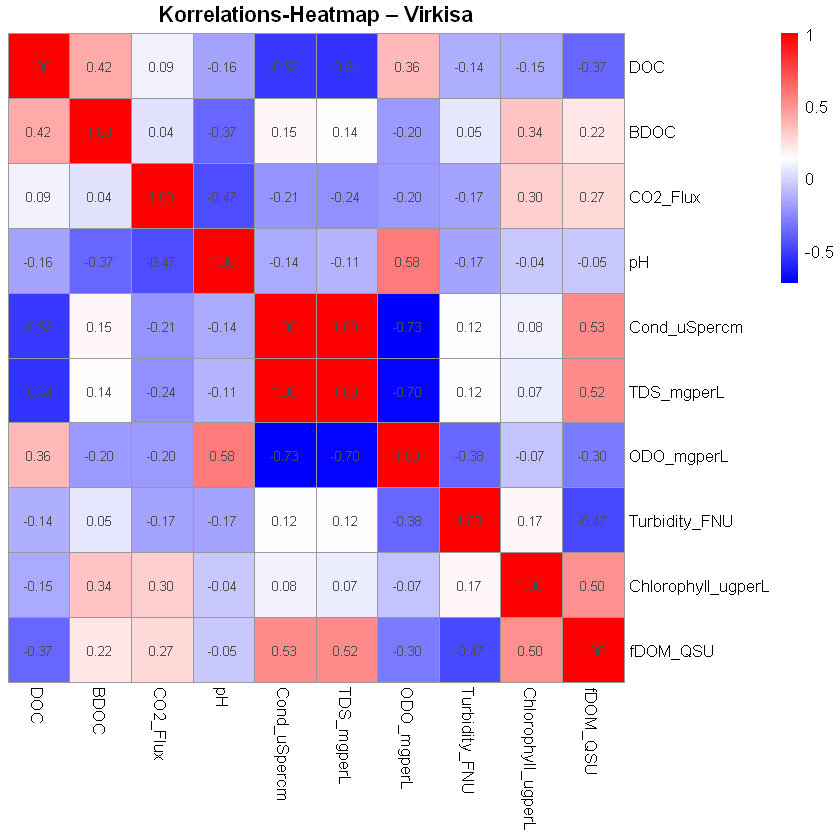

✅ PNG gespeichert unter: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/Chemisch/heatmap_Virkisa_group1_chemisch.png

📊 Verarbeite Gruppe: Virkisa (group_nr > 1)

✅ Stichprobenanzahl: 74



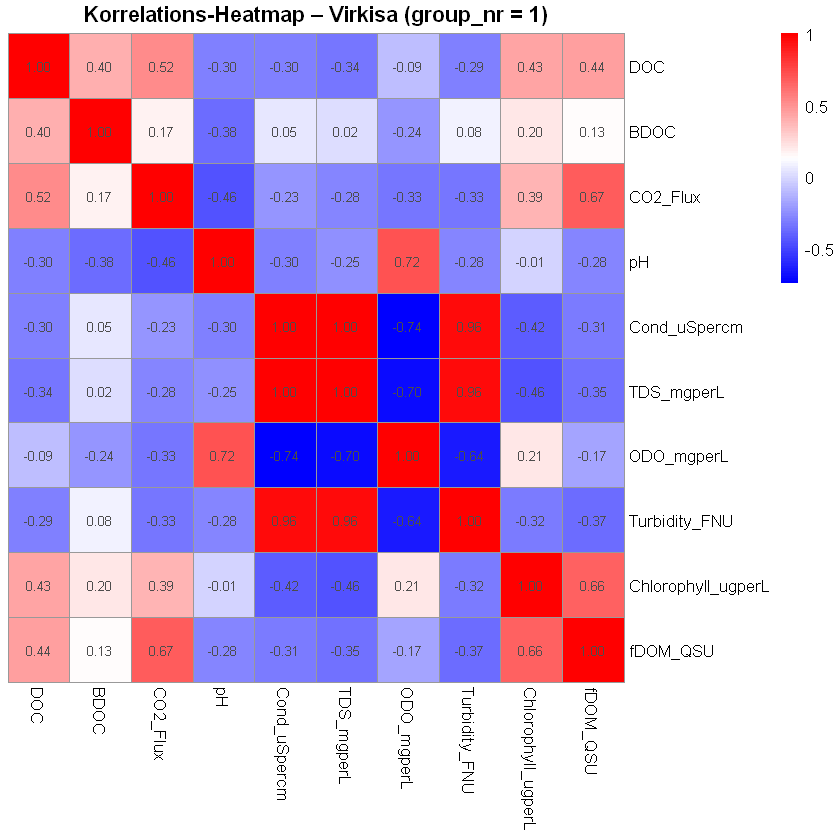

✅ PNG gespeichert unter: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/Chemisch/heatmap_Virkisa_group_gt1_chemisch.png



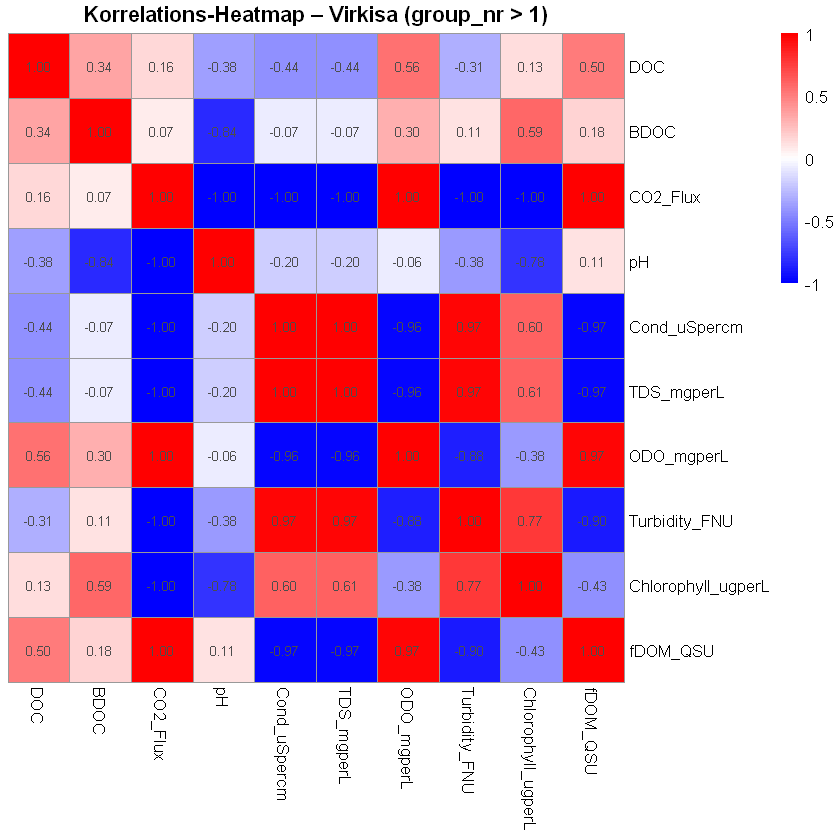

In [4]:
plot_and_save_chem_heatmap(df, 'river_name == "Vestari_Joekulsa"', "Vestari_Joekulsa", "Vestari_Joekulsa")
plot_and_save_chem_heatmap(df, 'river_name == "Virkisa"', "Virkisa", "Virkisa")
plot_and_save_chem_heatmap(df, 'river_name == "Virkisa" & group_nr == 1', "Virkisa_group1", "Virkisa (group_nr = 1)")
plot_and_save_chem_heatmap(df, 'river_name == "Virkisa" & group_nr > 1', "Virkisa_group_gt1", "Virkisa (group_nr > 1)")


# Heatmap für fluoreszierende Parameter


In [5]:
# 📦 Pakete laden
library(readxl)
library(dplyr)
library(pheatmap)
library(grid)
library(rlang)

# 📥 Daten einlesen
data_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA.xlsx"
df <- read_excel(data_path, sheet = "FINAL_final_final")

# ✂️ Spalten aufräumen
colnames(df) <- trimws(colnames(df))
df$river_name <- trimws(as.character(df$river_name))
df$group_nr <- as.numeric(df$group_nr)

# 📁 Zielordner für fluoreszierende Heatmaps
output_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/Fluo"

# 🔬 BDOC-Fluoreszenz + Kohlenstoff-Variablen
all_vars <- c(
  "bix_bdoc", "hix_bdoc", "fi_bdoc", 
  "E2_E3_bdoc", "SR_bdoc", 
  "a254_bdoc", "a300_bdoc", 
  "S275_295_bdoc", "S350_400_bdoc",
  "DOC", "BDOC", "CO2_Flux"
)

# 🔁 Funktion zur Erstellung & Speicherung der Heatmap
plot_and_save_fluo_heatmap <- function(data, filter_expr, filename_suffix, title_suffix) {
  message("📊 Verarbeite: ", title_suffix)

  df_filtered <- data %>% filter(!!parse_expr(filter_expr))

  selected_vars <- df_filtered %>%
    select(any_of(all_vars)) %>%
    mutate(across(everything(), as.numeric))

  message("✅ Stichprobenanzahl: ", nrow(selected_vars))

  if (ncol(selected_vars) < 2 || nrow(selected_vars) < 2) {
    message("⚠️ Nicht genügend Daten für: ", title_suffix)
    return(NULL)
  }

  cor_matrix <- cor(selected_vars, use = "pairwise.complete.obs")

  # Fehlende Variablen ergänzen
  missing_vars <- setdiff(all_vars, rownames(cor_matrix))
  for (var in missing_vars) {
    cor_matrix <- rbind(cor_matrix, setNames(rep(NA, ncol(cor_matrix)), colnames(cor_matrix)))
    rownames(cor_matrix)[nrow(cor_matrix)] <- var
    cor_matrix <- cbind(cor_matrix, setNames(rep(NA, nrow(cor_matrix)), var))
  }

  cor_matrix <- cor_matrix[all_vars, all_vars]

  # 🔥 Heatmap erzeugen (und speichern)
  p <- pheatmap(
    cor_matrix,
    cluster_rows = FALSE,
    cluster_cols = FALSE,
    display_numbers = TRUE,
    number_format = "%.2f",
    color = colorRampPalette(c("blue", "white", "red"))(100),
    main = paste("Korrelations-Heatmap –", title_suffix, "(BDOC Fluoreszenz + C)"),
    na_col = "grey80",
    silent = TRUE
  )

  # 📺 Anzeige im Notebook
  grid.newpage()
  grid.draw(p$gtable)

  # 💾 Speichern als PNG
  file_path <- file.path(output_dir, paste0("heatmap_", filename_suffix, "_fluo.png"))
  png(file_path, width = 2000, height = 1800, res = 250)
  grid.newpage()
  grid.draw(p$gtable)
  dev.off()

  message("✅ PNG gespeichert unter: ", file_path)
}


New names:
• `SpCond_uSpercm` -> `SpCond_uSpercm...41`
• `SpCond_uSpercm` -> `SpCond_uSpercm...42`


📊 Verarbeite: Vestari_Joekulsa

Warning message:
"There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `across(everything(), as.numeric)`.
Caused by warning:
! NAs durch Umwandlung erzeugt
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning."
✅ Stichprobenanzahl: 41

✅ PNG gespeichert unter: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/Fluo/heatmap_Vestari_Joekulsa_fluo.png

📊 Verarbeite: Virkisa

✅ Stichprobenanzahl: 106



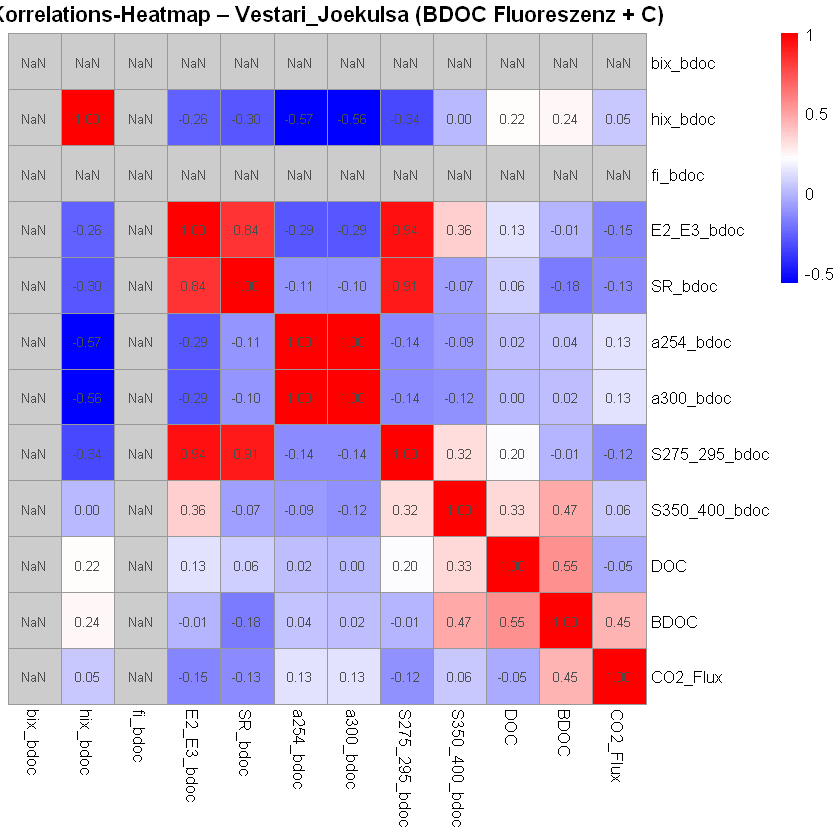

✅ PNG gespeichert unter: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/Fluo/heatmap_Virkisa_fluo.png

📊 Verarbeite: Virkisa (group_nr = 1)

✅ Stichprobenanzahl: 32



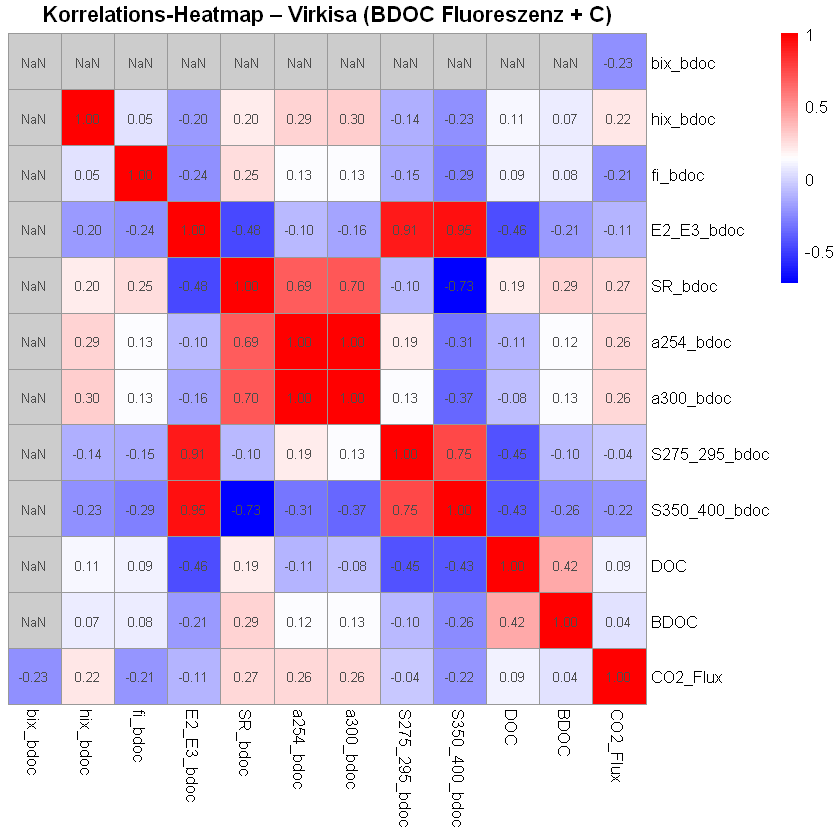

✅ PNG gespeichert unter: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/Fluo/heatmap_Virkisa_group1_fluo.png

📊 Verarbeite: Virkisa (group_nr > 1)

✅ Stichprobenanzahl: 74



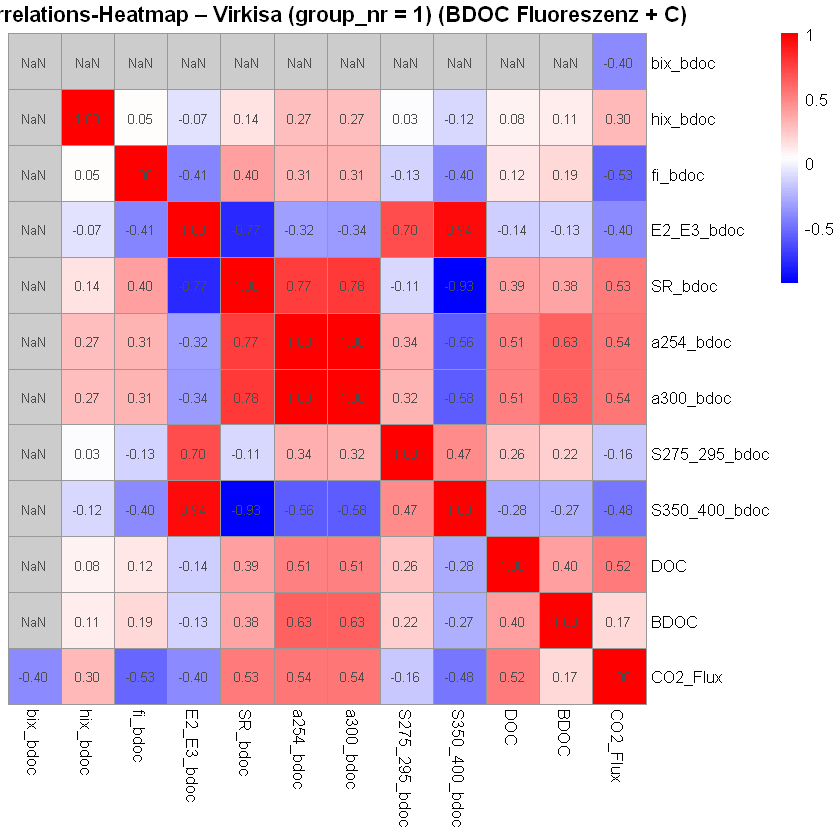

✅ PNG gespeichert unter: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/Fluo/heatmap_Virkisa_group_gt1_fluo.png



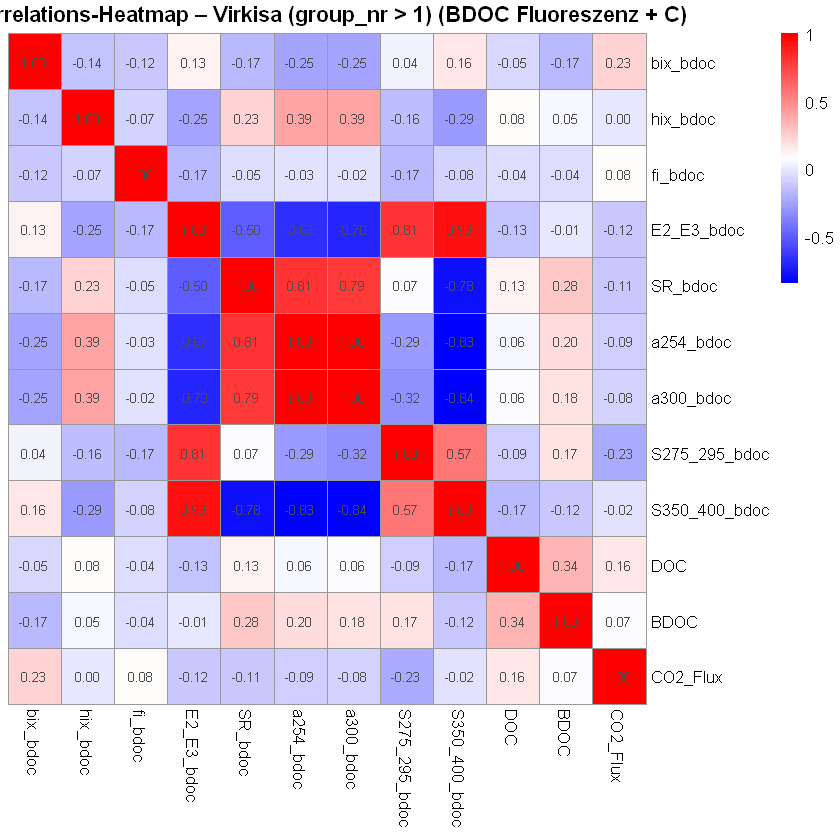

In [6]:
plot_and_save_fluo_heatmap(df, 'river_name == "Vestari_Joekulsa"', "Vestari_Joekulsa", "Vestari_Joekulsa")
plot_and_save_fluo_heatmap(df, 'river_name == "Virkisa"', "Virkisa", "Virkisa")
plot_and_save_fluo_heatmap(df, 'river_name == "Virkisa" & group_nr == 1', "Virkisa_group1", "Virkisa (group_nr = 1)")
plot_and_save_fluo_heatmap(df, 'river_name == "Virkisa" & group_nr > 1', "Virkisa_group_gt1", "Virkisa (group_nr > 1)")


# Komponenten-Heatmaps (DOC vs. BDOC)

In [7]:
# 📦 Pakete laden
library(readxl)
library(dplyr)
library(pheatmap)
library(grid)
library(rlang)

# 📥 Daten einlesen
data_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA.xlsx"
output_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/1_Komponenten"
df <- read_excel(data_path, sheet = "FINAL_final_final")

# 🧼 Spalten aufräumen
colnames(df) <- trimws(colnames(df))
df$river_name <- trimws(as.character(df$river_name))
df$group_nr <- as.numeric(df$group_nr)

# 🔬 DOC- und BDOC-Komponenten
comp_vars_doc <- c("Comp.1", "Comp.2", "Comp.3", "Comp.4", "Comp.5")
comp_vars_bdoc <- c("Comp.1_B", "Comp.2_B", "Comp.3_B", "Comp.4_B", "Comp.5_B")

# 🔁 Funktion zur Erstellung & Speicherung
plot_and_save_component_heatmap <- function(data, filter_expr, comp_vars, filename_suffix, title_suffix) {
  message("📊 Verarbeite: ", title_suffix)

  df_filtered <- data %>% filter(!!parse_expr(filter_expr))

  selected_vars <- df_filtered %>%
    select(any_of(comp_vars)) %>%
    mutate(across(everything(), as.numeric))

  message("✅ Stichprobenanzahl: ", nrow(selected_vars))

  if (ncol(selected_vars) == 0 || all(is.na(selected_vars))) {
    message("⚠️ Keine gültigen Daten für: ", title_suffix)
    return(NULL)
  }

  cor_matrix <- cor(selected_vars, use = "pairwise.complete.obs")

  missing_vars <- setdiff(comp_vars, rownames(cor_matrix))
  for (var in missing_vars) {
    cor_matrix <- rbind(cor_matrix, setNames(rep(NA, ncol(cor_matrix)), colnames(cor_matrix)))
    rownames(cor_matrix)[nrow(cor_matrix)] <- var
    cor_matrix <- cbind(cor_matrix, setNames(rep(NA, nrow(cor_matrix)), var))
  }

  cor_matrix <- cor_matrix[comp_vars, comp_vars]

  # 🔥 Heatmap erzeugen
  p <- pheatmap(
    cor_matrix,
    cluster_rows = FALSE,
    cluster_cols = FALSE,
    display_numbers = TRUE,
    number_format = "%.2f",
    color = colorRampPalette(c("blue", "white", "red"))(100),
    main = paste("Korrelations-Heatmap –", title_suffix),
    na_col = "grey80",
    silent = TRUE
  )

  # 📺 Notebook-Anzeige
  grid.newpage()
  grid.draw(p$gtable)

  # 💾 PNG speichern
  file_path <- file.path(output_dir, paste0("heatmap_", filename_suffix, ".png"))
  png(file_path, width = 2000, height = 1800, res = 250)
  grid.newpage()
  grid.draw(p$gtable)
  dev.off()

  message("✅ Gespeichert unter: ", file_path)
}


New names:
• `SpCond_uSpercm` -> `SpCond_uSpercm...41`
• `SpCond_uSpercm` -> `SpCond_uSpercm...42`


📊 Verarbeite: Vestari_Joekulsa (DOC Komponenten)

✅ Stichprobenanzahl: 41

✅ Gespeichert unter: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/1_Komponenten/heatmap_Vestari_Joekulsa_DOC.png

📊 Verarbeite: Virkisa (DOC Komponenten)

✅ Stichprobenanzahl: 106



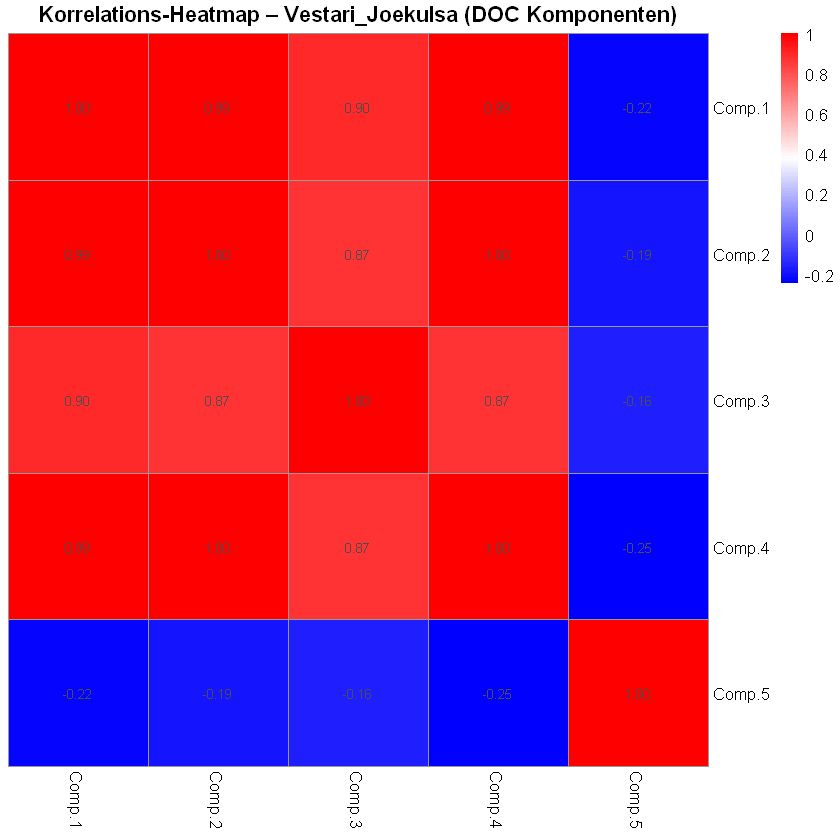

✅ Gespeichert unter: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/1_Komponenten/heatmap_Virkisa_DOC.png

📊 Verarbeite: Virkisa (group_nr = 1, DOC Komponenten)

✅ Stichprobenanzahl: 32



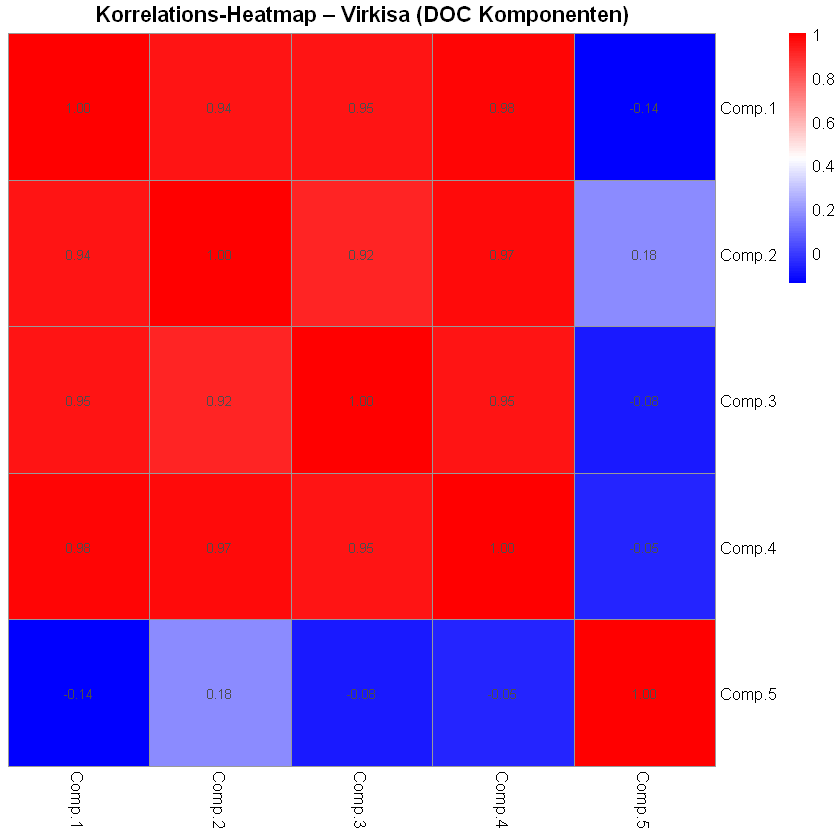

✅ Gespeichert unter: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/1_Komponenten/heatmap_Virkisa_group1_DOC.png

📊 Verarbeite: Virkisa (group_nr > 1, DOC Komponenten)

✅ Stichprobenanzahl: 74



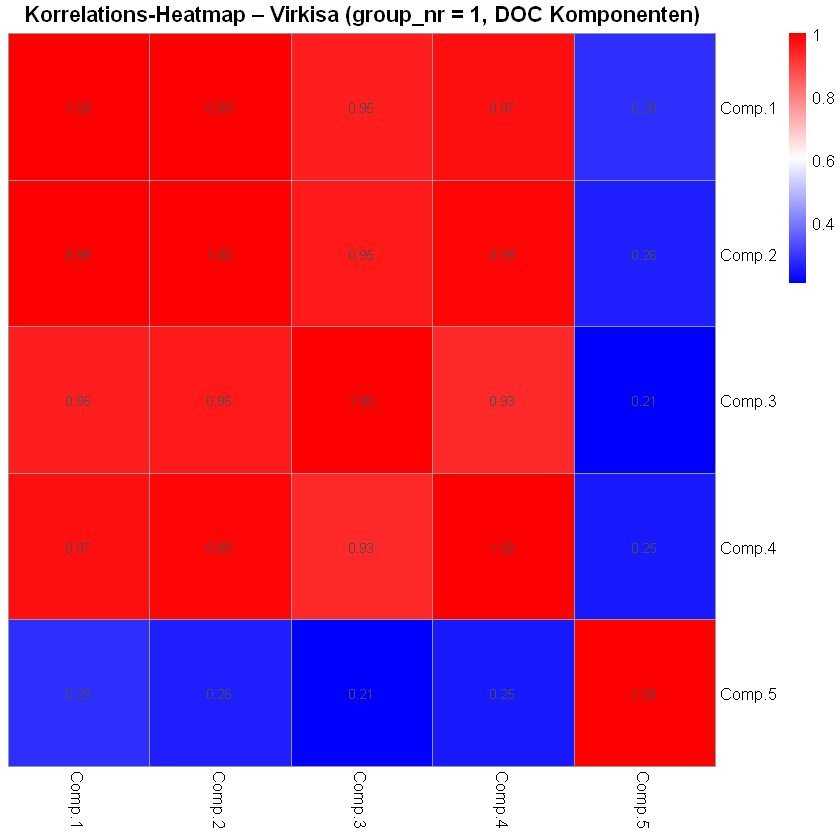

✅ Gespeichert unter: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/1_Komponenten/heatmap_Virkisa_group_gt1_DOC.png



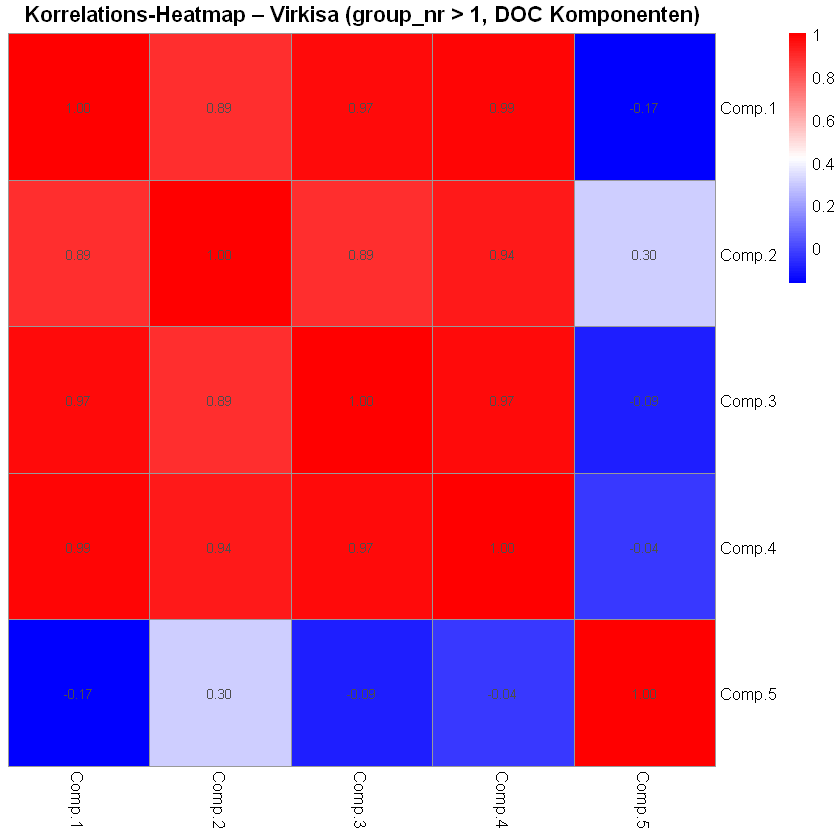

In [8]:
plot_and_save_component_heatmap(df, 'river_name == "Vestari_Joekulsa"', comp_vars_doc, "Vestari_Joekulsa_DOC", "Vestari_Joekulsa (DOC Komponenten)")
plot_and_save_component_heatmap(df, 'river_name == "Virkisa"', comp_vars_doc, "Virkisa_DOC", "Virkisa (DOC Komponenten)")
plot_and_save_component_heatmap(df, 'river_name == "Virkisa" & group_nr == 1', comp_vars_doc, "Virkisa_group1_DOC", "Virkisa (group_nr = 1, DOC Komponenten)")
plot_and_save_component_heatmap(df, 'river_name == "Virkisa" & group_nr > 1', comp_vars_doc, "Virkisa_group_gt1_DOC", "Virkisa (group_nr > 1, DOC Komponenten)")


📊 Verarbeite: Vestari_Joekulsa (BDOC Komponenten)

✅ Stichprobenanzahl: 41

✅ Gespeichert unter: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/1_Komponenten/heatmap_Vestari_Joekulsa_BDOC.png

📊 Verarbeite: Virkisa (BDOC Komponenten)

✅ Stichprobenanzahl: 106



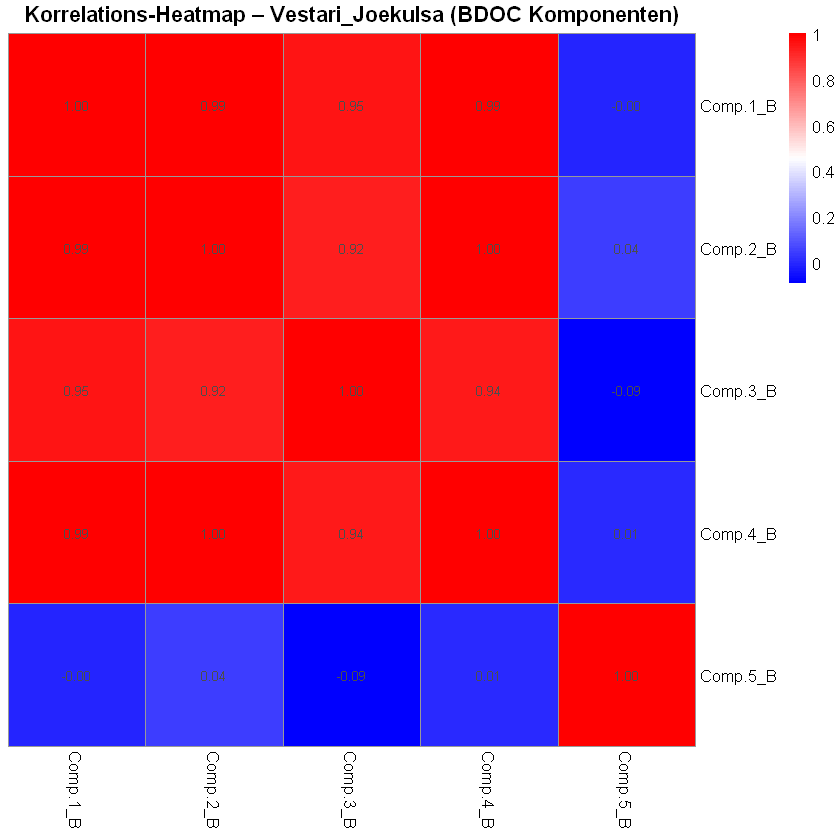

✅ Gespeichert unter: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/1_Komponenten/heatmap_Virkisa_BDOC.png

📊 Verarbeite: Virkisa (group_nr = 1, BDOC Komponenten)

✅ Stichprobenanzahl: 32



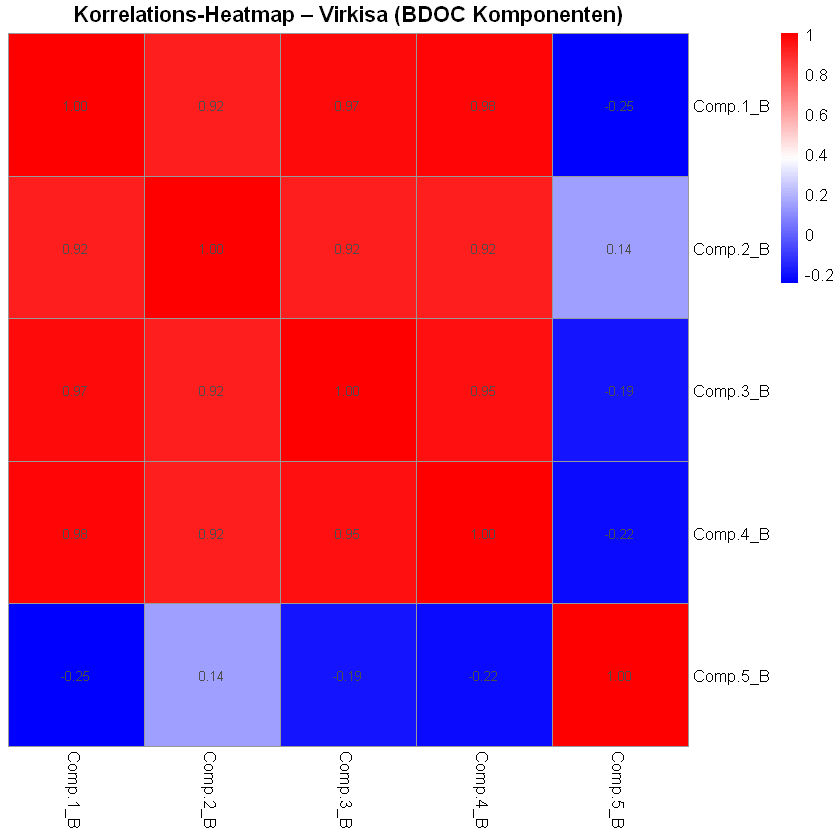

✅ Gespeichert unter: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/1_Komponenten/heatmap_Virkisa_group1_BDOC.png

📊 Verarbeite: Virkisa (group_nr > 1, BDOC Komponenten)

✅ Stichprobenanzahl: 74



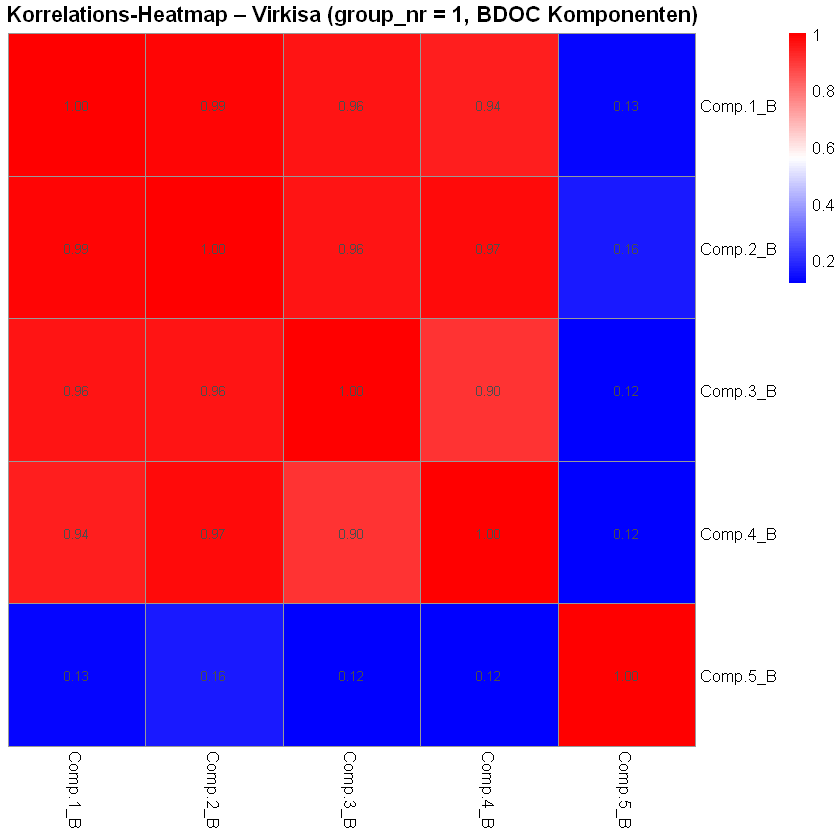

✅ Gespeichert unter: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/1_Komponenten/heatmap_Virkisa_group_gt1_BDOC.png



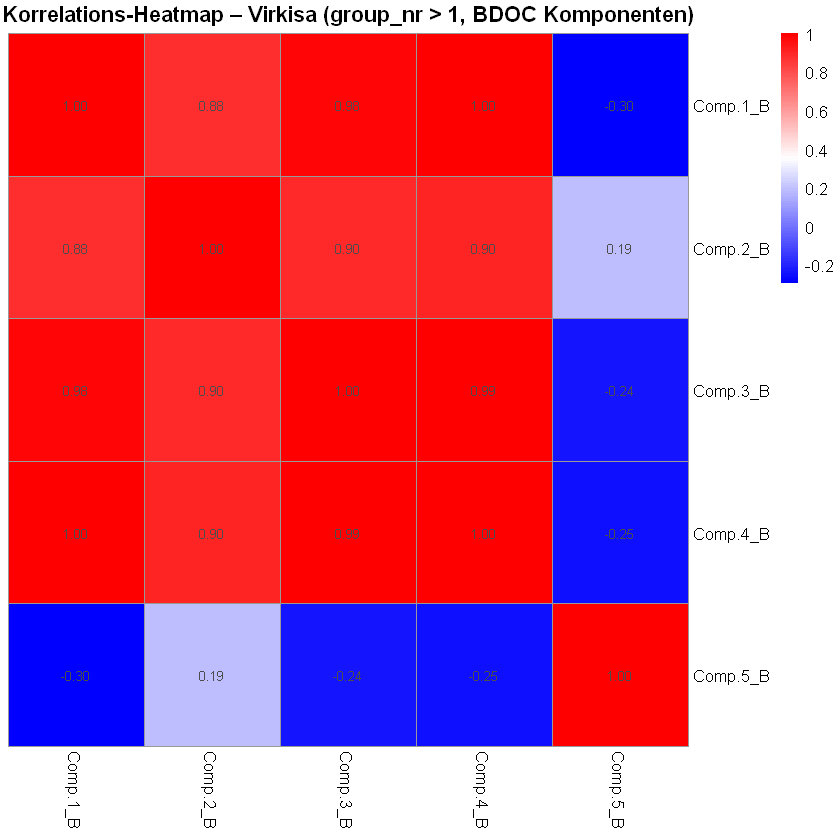

In [9]:
plot_and_save_component_heatmap(df, 'river_name == "Vestari_Joekulsa"', comp_vars_bdoc, "Vestari_Joekulsa_BDOC", "Vestari_Joekulsa (BDOC Komponenten)")
plot_and_save_component_heatmap(df, 'river_name == "Virkisa"', comp_vars_bdoc, "Virkisa_BDOC", "Virkisa (BDOC Komponenten)")
plot_and_save_component_heatmap(df, 'river_name == "Virkisa" & group_nr == 1', comp_vars_bdoc, "Virkisa_group1_BDOC", "Virkisa (group_nr = 1, BDOC Komponenten)")
plot_and_save_component_heatmap(df, 'river_name == "Virkisa" & group_nr > 1', comp_vars_bdoc, "Virkisa_group_gt1_BDOC", "Virkisa (group_nr > 1, BDOC Komponenten)")


#  pctComp.X Heatmaps


New names:
• `SpCond_uSpercm` -> `SpCond_uSpercm...41`
• `SpCond_uSpercm` -> `SpCond_uSpercm...42`
📊 Verarbeite: Vestari_Joekulsa (Prozentuale DOC-Komponenten)

✅ Stichprobenanzahl: 41

✅ PNG gespeichert: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/2_pctComp/heatmap_vestari_doc_pct.png

📊 Verarbeite: Virkisa (Prozentuale DOC-Komponenten)

✅ Stichprobenanzahl: 106

✅ PNG gespeichert: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/2_pctComp/heatmap_virkisa_doc_pct.png



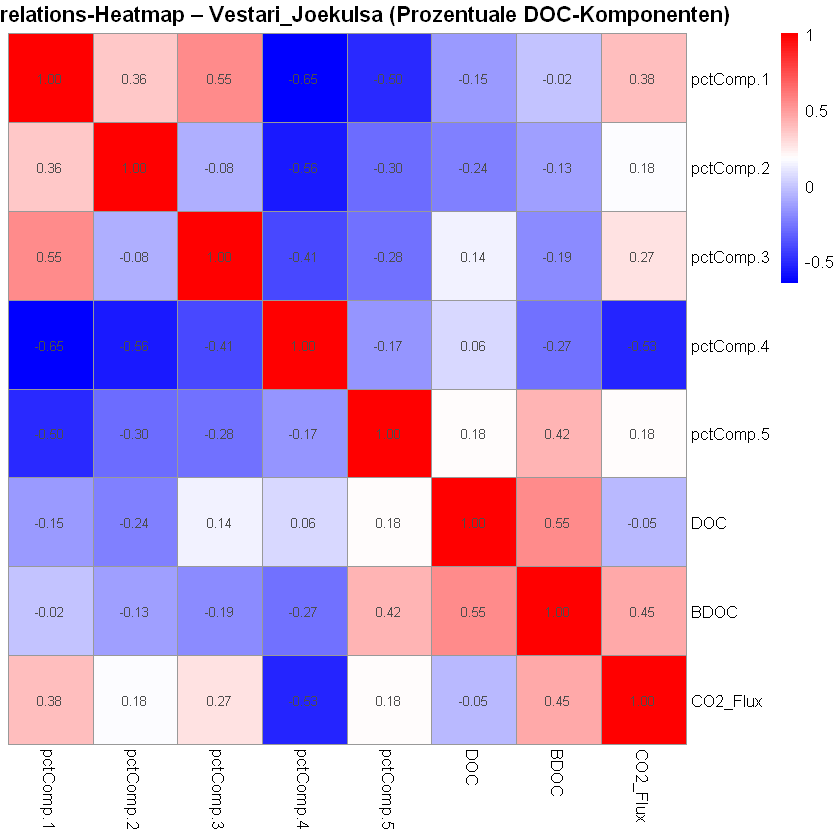

📊 Verarbeite: Virkisa (group_nr = 1, Prozentuale DOC-Komponenten)

✅ Stichprobenanzahl: 32

✅ PNG gespeichert: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/2_pctComp/heatmap_virkisa_doc_pct_group1.png



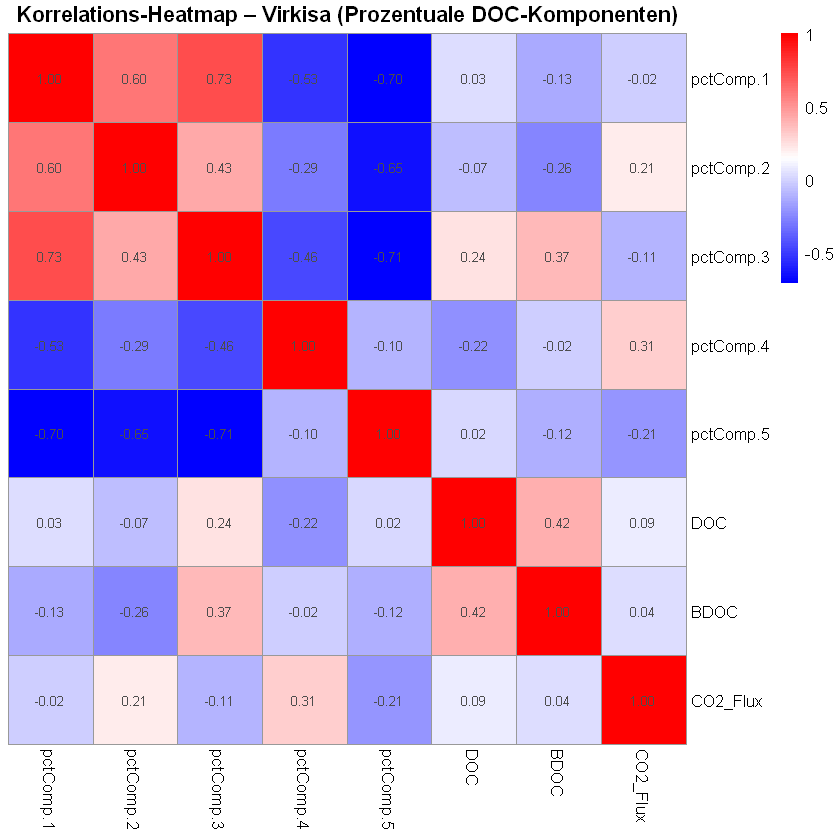

📊 Verarbeite: Virkisa (group_nr > 1, Prozentuale DOC-Komponenten)

✅ Stichprobenanzahl: 74

✅ PNG gespeichert: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/2_pctComp/heatmap_virkisa_doc_pct_group2.png



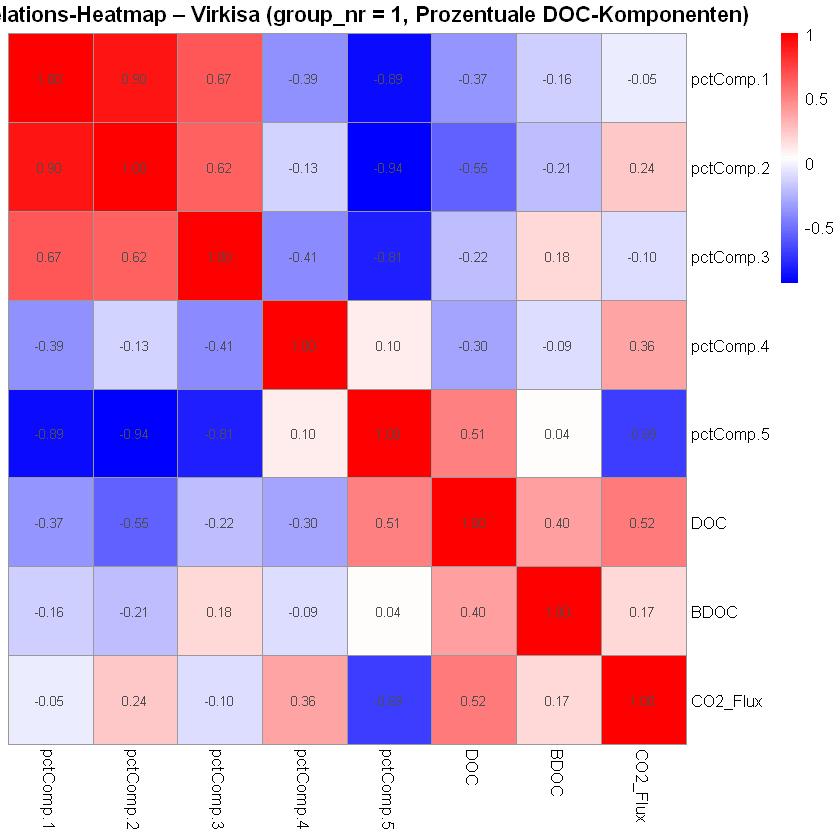

📊 Verarbeite: Vestari_Joekulsa (Prozentuale BDOC-Komponenten)

✅ Stichprobenanzahl: 41

✅ PNG gespeichert: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/2_pctComp/heatmap_vestari_bdoc_pct.png



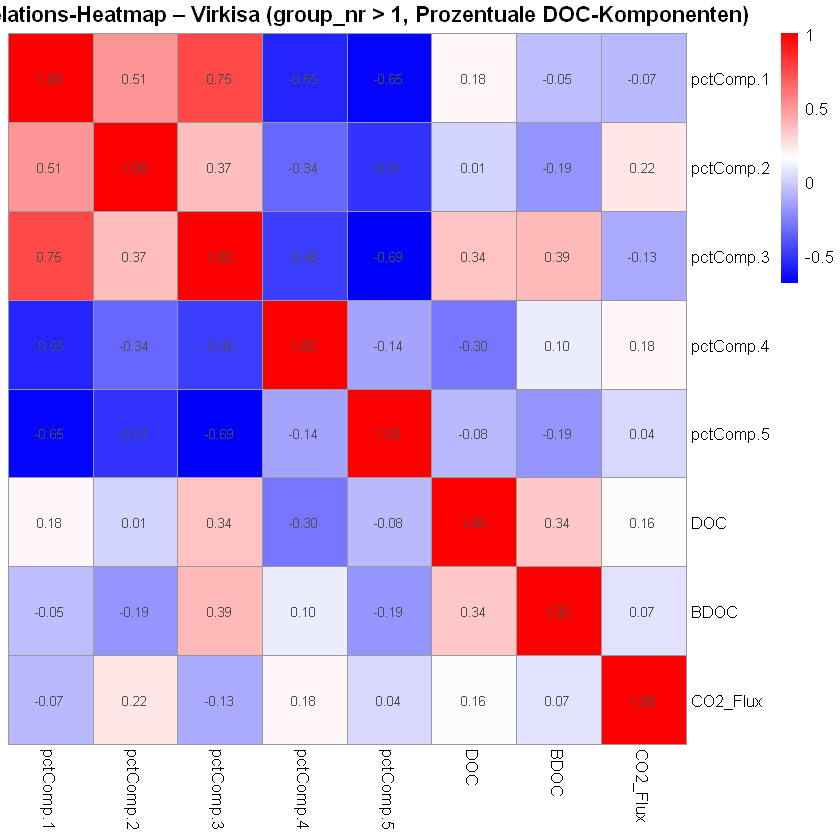

📊 Verarbeite: Virkisa (Prozentuale BDOC-Komponenten)

✅ Stichprobenanzahl: 106

✅ PNG gespeichert: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/2_pctComp/heatmap_virkisa_bdoc_pct.png



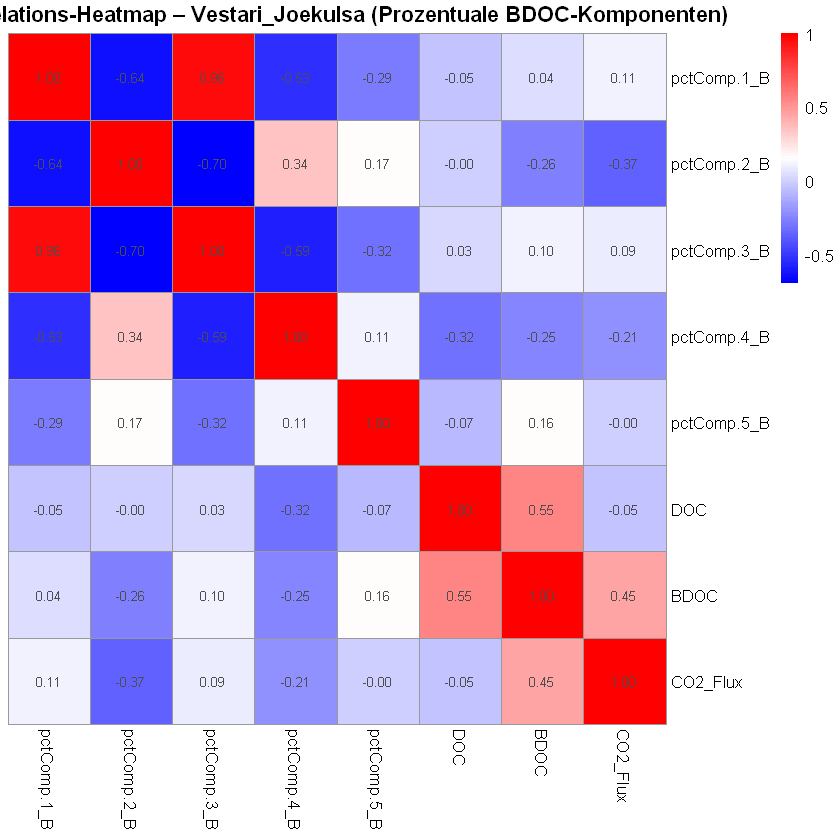

📊 Verarbeite: Virkisa (group_nr = 1, Prozentuale BDOC-Komponenten)

✅ Stichprobenanzahl: 32

✅ PNG gespeichert: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/2_pctComp/heatmap_virkisa_bdoc_pct_group1.png



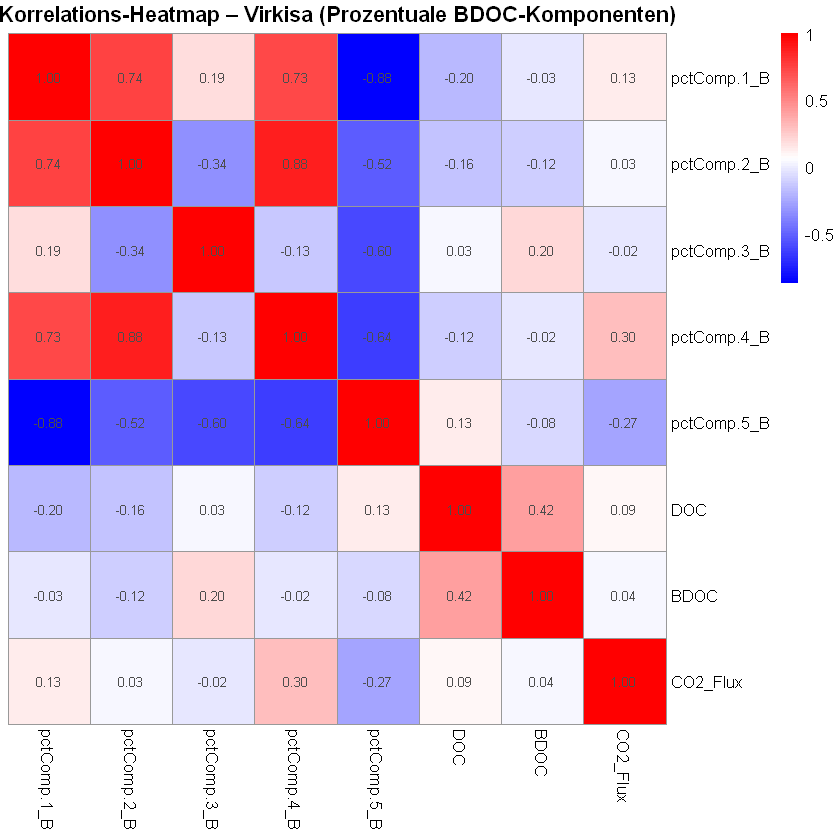

📊 Verarbeite: Virkisa (group_nr > 1, Prozentuale BDOC-Komponenten)

✅ Stichprobenanzahl: 74

✅ PNG gespeichert: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/2_pctComp/heatmap_virkisa_bdoc_pct_group2.png



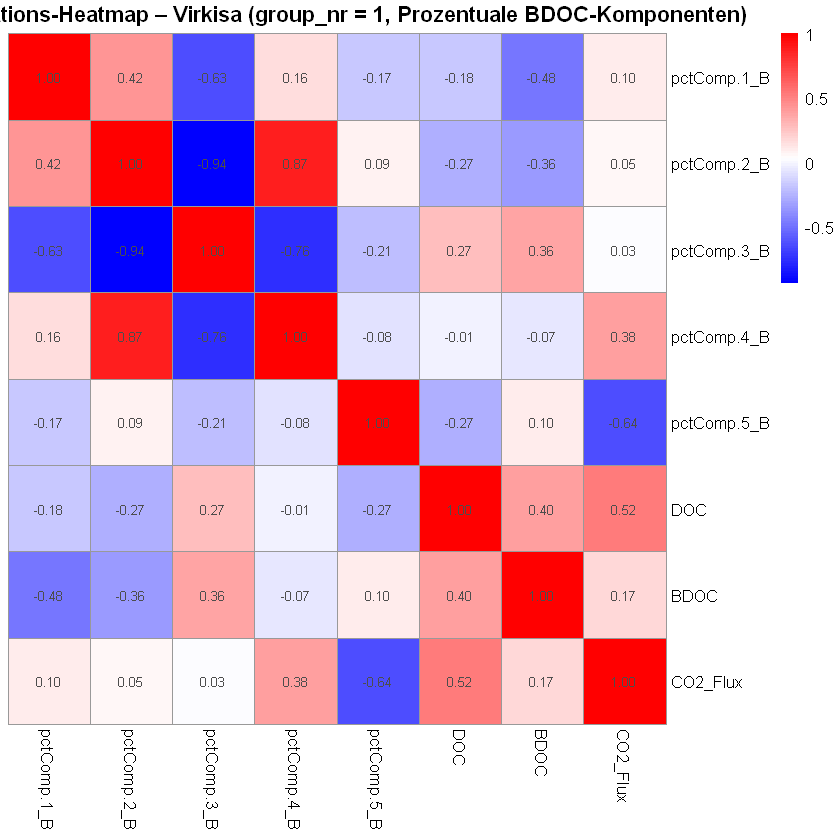

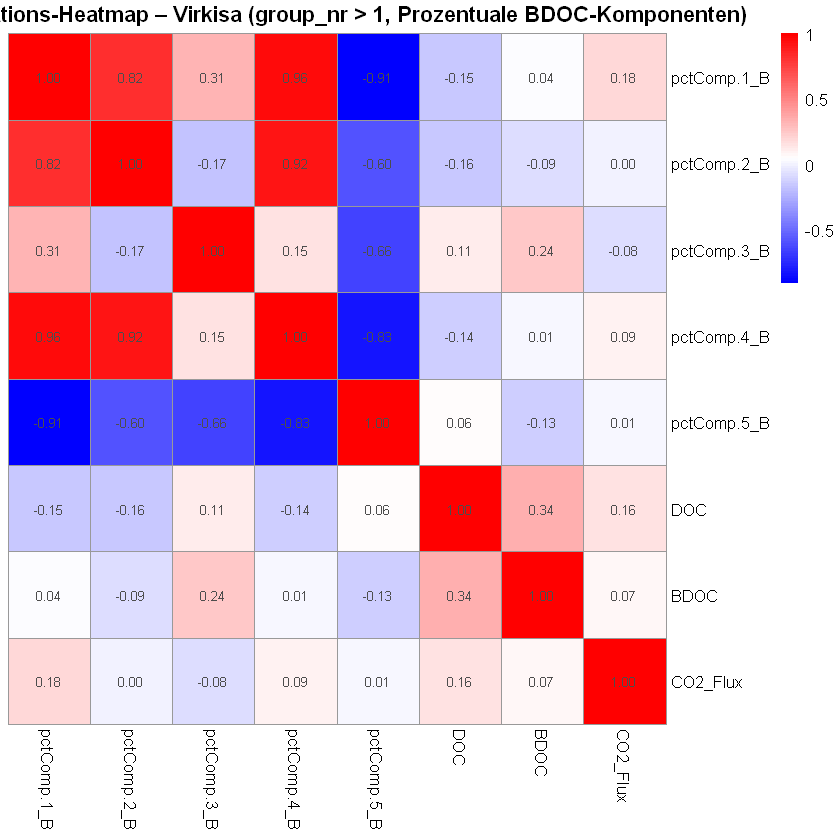

In [10]:
# install.packages("pheatmap")  # Nur falls nötig

library(readxl)
library(dplyr)
library(pheatmap)
library(rlang)
library(grid)

# 📥 Excel-Datei laden
data_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA.xlsx"
df <- read_excel(data_path, sheet = "FINAL_final_final")

# 🧼 Spalten aufräumen
colnames(df) <- trimws(colnames(df))
df$river_name <- trimws(as.character(df$river_name))
df$group_nr <- as.numeric(df$group_nr)

# 🔬 Variablen
pct_vars_doc <- c("pctComp.1", "pctComp.2", "pctComp.3", "pctComp.4", "pctComp.5")
pct_vars_bdoc <- c("pctComp.1_B", "pctComp.2_B", "pctComp.3_B", "pctComp.4_B", "pctComp.5_B")
carbon_vars <- c("DOC", "BDOC", "CO2_Flux")

# 📁 Zielordner für PNG-Dateien
output_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/2_pctComp"

# 📊 Funktion für Heatmap-Erstellung + PNG-Speicherung
plot_pct_heatmap_by_filter <- function(data, filter_expr, pct_vars, title_suffix, filename_suffix) {
  message("📊 Verarbeite: ", title_suffix)

  df_filtered <- data %>% filter(!!rlang::parse_expr(filter_expr))
  all_vars <- c(pct_vars, carbon_vars)

  selected_vars <- df_filtered %>%
    select(any_of(all_vars)) %>%
    mutate(across(everything(), as.numeric))

  message("✅ Stichprobenanzahl: ", nrow(selected_vars))

  if (ncol(selected_vars) == 0 || all(is.na(selected_vars))) {
    message("⚠️ Keine gültigen Daten für: ", title_suffix)
    return(NULL)
  }

  cor_matrix <- cor(selected_vars, use = "pairwise.complete.obs")

  missing_vars <- setdiff(all_vars, rownames(cor_matrix))
  for (var in missing_vars) {
    cor_matrix <- rbind(cor_matrix, setNames(rep(NA, ncol(cor_matrix)), colnames(cor_matrix)))
    rownames(cor_matrix)[nrow(cor_matrix)] <- var
    cor_matrix <- cbind(cor_matrix, setNames(rep(NA, nrow(cor_matrix)), var))
  }
  cor_matrix <- cor_matrix[all_vars, all_vars]

  # Heatmap-Objekt generieren
  p <- pheatmap(
    cor_matrix,
    cluster_rows = FALSE,
    cluster_cols = FALSE,
    display_numbers = TRUE,
    number_format = "%.2f",
    color = colorRampPalette(c("blue", "white", "red"))(100),
    main = paste("Korrelations-Heatmap –", title_suffix),
    na_col = "grey80",
    silent = TRUE
  )

  # PNG speichern
  file_path <- file.path(output_dir, paste0("heatmap_", filename_suffix, ".png"))
  png(file_path, width = 2000, height = 1800, res = 250)
  grid.newpage()
  grid.draw(p$gtable)
  dev.off()
  message("✅ PNG gespeichert: ", file_path)

  # Heatmap auch im Notebook anzeigen
  grid.newpage()
  grid.draw(p$gtable)
}

# 🔷 DOC-Prozent-Komponenten
plot_pct_heatmap_by_filter(df, 'river_name == "Vestari_Joekulsa"', pct_vars_doc, "Vestari_Joekulsa (Prozentuale DOC-Komponenten)", "vestari_doc_pct")
plot_pct_heatmap_by_filter(df, 'river_name == "Virkisa"', pct_vars_doc, "Virkisa (Prozentuale DOC-Komponenten)", "virkisa_doc_pct")
plot_pct_heatmap_by_filter(df, 'river_name == "Virkisa" & group_nr == 1', pct_vars_doc, "Virkisa (group_nr = 1, Prozentuale DOC-Komponenten)", "virkisa_doc_pct_group1")
plot_pct_heatmap_by_filter(df, 'river_name == "Virkisa" & group_nr > 1', pct_vars_doc, "Virkisa (group_nr > 1, Prozentuale DOC-Komponenten)", "virkisa_doc_pct_group2")

# 🔶 BDOC-Prozent-Komponenten
plot_pct_heatmap_by_filter(df, 'river_name == "Vestari_Joekulsa"', pct_vars_bdoc, "Vestari_Joekulsa (Prozentuale BDOC-Komponenten)", "vestari_bdoc_pct")
plot_pct_heatmap_by_filter(df, 'river_name == "Virkisa"', pct_vars_bdoc, "Virkisa (Prozentuale BDOC-Komponenten)", "virkisa_bdoc_pct")
plot_pct_heatmap_by_filter(df, 'river_name == "Virkisa" & group_nr == 1', pct_vars_bdoc, "Virkisa (group_nr = 1, Prozentuale BDOC-Komponenten)", "virkisa_bdoc_pct_group1")
plot_pct_heatmap_by_filter(df, 'river_name == "Virkisa" & group_nr > 1', pct_vars_bdoc, "Virkisa (group_nr > 1, Prozentuale BDOC-Komponenten)", "virkisa_bdoc_pct_group2")


# ✅  DOC vs. BDOC Komponenten (gemeinsame Heatmap)

New names:
• `SpCond_uSpercm` -> `SpCond_uSpercm...41`
• `SpCond_uSpercm` -> `SpCond_uSpercm...42`
📊 Vergleiche DOC vs. BDOC (inkl. Kohlenstoff) für: Vestari_Joekulsa

✅ PNG gespeichert: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/3_komponente_gemeinsam/heatmap_doc_vs_bdoc_vestari.png

📊 Vergleiche DOC vs. BDOC (inkl. Kohlenstoff) für: Virkisa

✅ PNG gespeichert: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/3_komponente_gemeinsam/heatmap_doc_vs_bdoc_virkisa.png



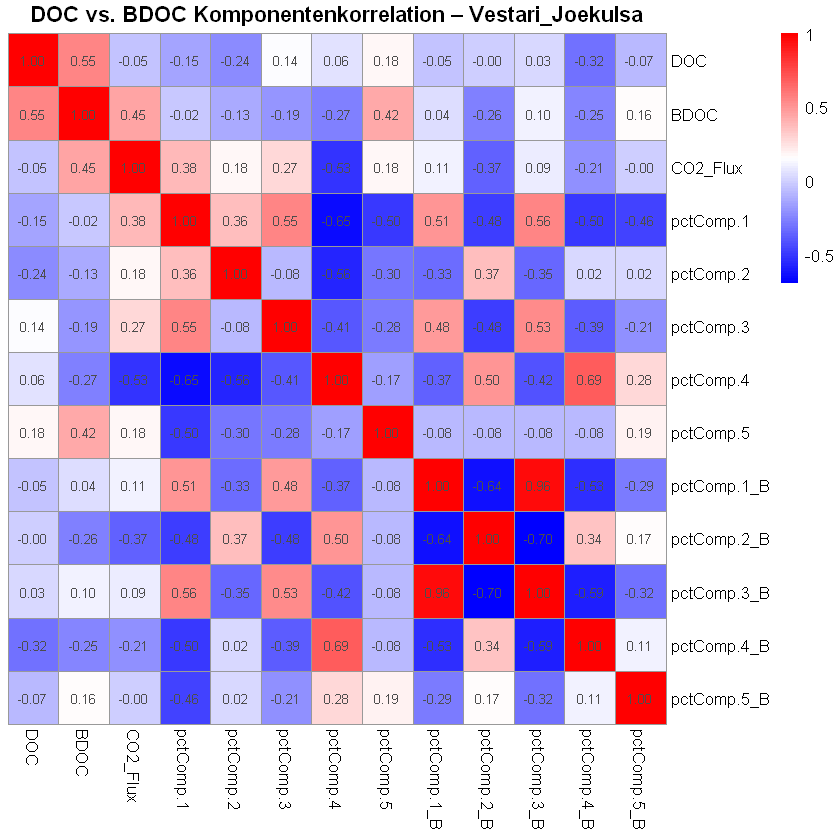

📊 Vergleiche DOC vs. BDOC (inkl. Kohlenstoff) für: Virkisa (group_nr = 1)

✅ PNG gespeichert: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/3_komponente_gemeinsam/heatmap_doc_vs_bdoc_virkisa_group1.png



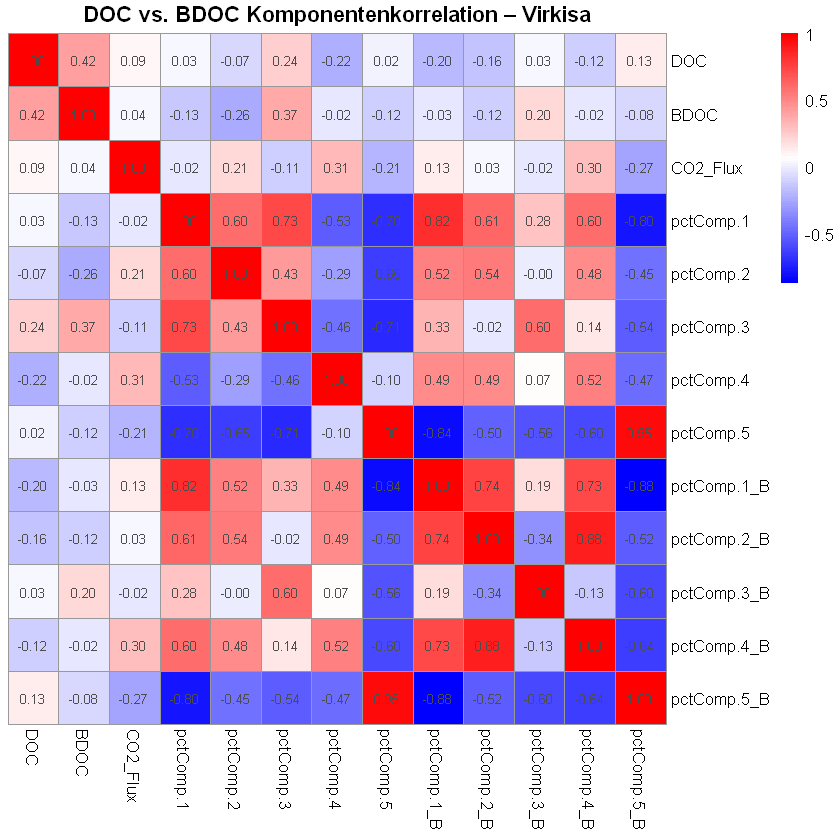

📊 Vergleiche DOC vs. BDOC (inkl. Kohlenstoff) für: Virkisa (group_nr > 1)

✅ PNG gespeichert: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/3_komponente_gemeinsam/heatmap_doc_vs_bdoc_virkisa_group2.png



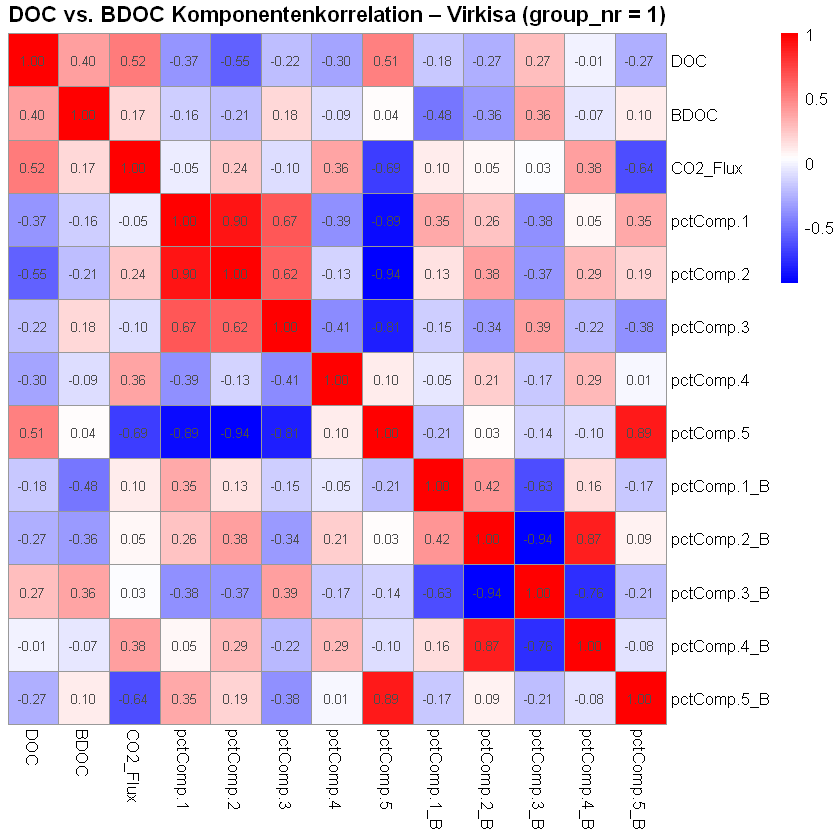

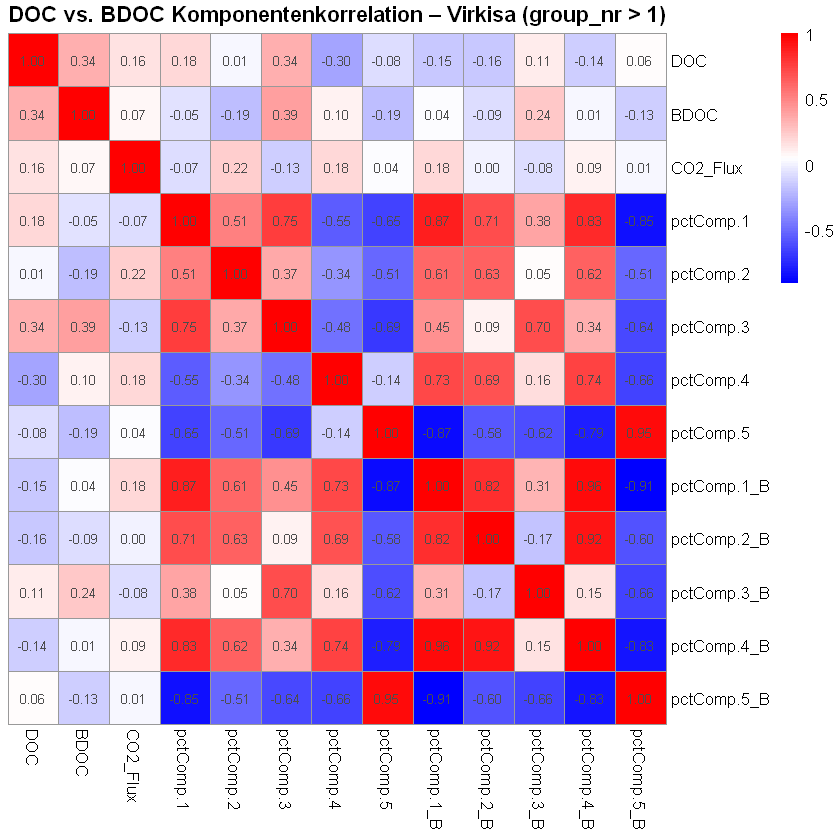

In [4]:
# install.packages("pheatmap")  # Nur falls nötig

library(readxl)
library(dplyr)
library(pheatmap)
library(grid)
library(rlang)

# 📥 Excel-Datei laden
data_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA.xlsx"
df <- read_excel(data_path, sheet = "FINAL_final_final")

# 🧼 Spalten bereinigen
colnames(df) <- trimws(colnames(df))
df$river_name <- trimws(as.character(df$river_name))
df$group_nr <- as.numeric(df$group_nr)

# 🔬 Prozent-Komponenten + Kohlenstoffvariablen
pct_doc <- c("pctComp.1", "pctComp.2", "pctComp.3", "pctComp.4", "pctComp.5")
pct_bdoc <- c("pctComp.1_B", "pctComp.2_B", "pctComp.3_B", "pctComp.4_B", "pctComp.5_B")
carbon_vars <- c("DOC", "BDOC", "CO2_Flux")
all_vars <- c(carbon_vars, pct_doc, pct_bdoc)

# 📁 Zielordner
output_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/3_komponente_gemeinsam"

# 🔁 Funktion zur Erstellung + Speicherung
plot_doc_vs_bdoc_pct_by_filter <- function(data, filter_expr, title_suffix, filename_suffix) {
  message("📊 Vergleiche DOC vs. BDOC (inkl. Kohlenstoff) für: ", title_suffix)

  df_filtered <- data %>% filter(!!parse_expr(filter_expr))

  selected_vars <- df_filtered %>%
    select(any_of(all_vars)) %>%
    mutate(across(everything(), as.numeric))

  if (ncol(selected_vars) == 0 || all(is.na(selected_vars))) {
    message("⚠️ Keine gültigen Daten für: ", title_suffix)
    return(NULL)
  }

  cor_matrix <- cor(selected_vars, use = "pairwise.complete.obs")

  # Fehlende Variablen ergänzen (für gleichmäßige Matrix)
  missing_vars <- setdiff(all_vars, rownames(cor_matrix))
  for (var in missing_vars) {
    cor_matrix <- rbind(cor_matrix, setNames(rep(NA, ncol(cor_matrix)), colnames(cor_matrix)))
    rownames(cor_matrix)[nrow(cor_matrix)] <- var
    cor_matrix <- cbind(cor_matrix, setNames(rep(NA, nrow(cor_matrix)), var))
  }

  cor_matrix <- cor_matrix[all_vars, all_vars]

  # 🔥 Heatmap erzeugen
  p <- pheatmap(
    cor_matrix,
    cluster_rows = FALSE,
    cluster_cols = FALSE,
    display_numbers = TRUE,
    number_format = "%.2f",
    color = colorRampPalette(c("blue", "white", "red"))(100),
    main = paste("DOC vs. BDOC Komponentenkorrelation –", title_suffix),
    na_col = "grey80",
    silent = TRUE
  )

  # 💾 PNG speichern
  file_path <- file.path(output_dir, paste0("heatmap_doc_vs_bdoc_", filename_suffix, ".png"))
  png(file_path, width = 2000, height = 1800, res = 250)
  grid.newpage()
  grid.draw(p$gtable)
  dev.off()
  message("✅ PNG gespeichert: ", file_path)

  # 📺 Auch im Notebook anzeigen
  grid.newpage()
  grid.draw(p$gtable)
}

# 🔷 Heatmaps generieren
plot_doc_vs_bdoc_pct_by_filter(df, 'river_name == "Vestari_Joekulsa"', "Vestari_Joekulsa", "vestari")
plot_doc_vs_bdoc_pct_by_filter(df, 'river_name == "Virkisa"', "Virkisa", "virkisa")
plot_doc_vs_bdoc_pct_by_filter(df, 'river_name == "Virkisa" & group_nr == 1', "Virkisa (group_nr = 1)", "virkisa_group1")
plot_doc_vs_bdoc_pct_by_filter(df, 'river_name == "Virkisa" & group_nr > 1', "Virkisa (group_nr > 1)", "virkisa_group2")


# Generator

In [ ]:
# 📦 Pakete laden
library(readxl)
library(dplyr)
library(pheatmap)
library(grid)

# 📥 Daten einlesen
data_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA.xlsx"
df <- read_excel(data_path, sheet = "FINAL_final_final")

# ✂️ Spalten bereinigen
colnames(df) <- trimws(colnames(df))
df$river_name <- trimws(as.character(df$river_name))
df$group_nr <- as.numeric(df$group_nr)

# 🔧 Generische Heatmap-Funktion
generate_heatmaps <- function(data, variable_list, filter_list, save_dir, title_prefix = "", filename_prefix = "") {
  for (filter_expr in names(filter_list)) {
    title_suffix <- filter_list[[filter_expr]]
    message("\U0001F4CA Verarbeite: ", title_suffix)

    df_filtered <- data %>% filter(!!rlang::parse_expr(filter_expr))

    selected_vars <- df_filtered %>%
      select(any_of(variable_list)) %>%
      mutate(across(everything(), as.numeric))

    if (ncol(selected_vars) < 2 || nrow(selected_vars) < 2) {
      message("⚠️ Nicht genügend gültige Daten für: ", title_suffix)
      next
    }

    cor_matrix <- cor(selected_vars, use = "pairwise.complete.obs")

    missing_vars <- setdiff(variable_list, rownames(cor_matrix))
    for (var in missing_vars) {
      cor_matrix <- rbind(cor_matrix, setNames(rep(NA, ncol(cor_matrix)), colnames(cor_matrix)))
      rownames(cor_matrix)[nrow(cor_matrix)] <- var
      cor_matrix <- cbind(cor_matrix, setNames(rep(NA, nrow(cor_matrix)), var))
    }

    cor_matrix <- cor_matrix[variable_list, variable_list]

    # Heatmap als Objekt
    p <- pheatmap(
      cor_matrix,
      cluster_rows = FALSE,
      cluster_cols = FALSE,
      display_numbers = TRUE,
      number_format = "%.2f",
      color = colorRampPalette(c("blue", "white", "red"))(100),
      main = paste("Korrelations-Heatmap –", title_suffix),
      na_col = "grey80",
      silent = TRUE
    )

    # Heatmap anzeigen
    grid.newpage()
    grid.draw(p$gtable)

    # Heatmap speichern
    filename <- paste0(filename_prefix, gsub("[^a-zA-Z0-9]", "_", title_suffix), ".png")
    filepath <- file.path(save_dir, filename)
    png(filepath, width = 2000, height = 1800, res = 250)
    grid.newpage()
    grid.draw(p$gtable)
    dev.off()

    message("✅ Gespeichert unter: ", filepath)
  }
}

# ✨ Beispiel: Wetter- & Kohlenstoff-Variablen
weather_vars <- c("DOC", "BDOC", "CO2_Flux", "Air_temp", "Min_temp", "Max_temp", "Wind_speed_mpers", "Precipitation_in_past_hour_mm", "Air_pressure_hPa")
filters <- list(
  "river_name == 'Vestari_Joekulsa'" = "Vestari_Joekulsa",
  "river_name == 'Virkisa'" = "Virkisa",
  "river_name == 'Virkisa' & group_nr == 1" = "Virkisa (group_nr = 1)",
  "river_name == 'Virkisa' & group_nr > 1" = "Virkisa (group_nr > 1)"
)

# 🔁 Heatmaps erzeugen und speichern
generate_heatmaps(
  data = df,
  variable_list = weather_vars,
  filter_list = filters,
  save_dir = "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Heatmaps_Variables/Wetter",
  title_prefix = "Wetter",
  filename_prefix = "wetter_"
)

# ✨ Weitere Aufrufe analog für andere Kategorien (chemisch, Fluo, Komponenten) kannst du nun mit wenigen Zeilen definieren!
